# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime as dt
import xgboost as xgb
import random
import pickle
import requests
import nbconvert
import sklearn


from IPython.display          import display, HTML
from datetime                 import datetime, timedelta
from matplotlib               import pyplot as plt
from IPython.display          import Image
from tabulate                 import tabulate
from scipy                    import stats
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                   import BorutaPy
from sklearn.ensemble         import RandomForestRegressor
from matplotlib.gridspec      import GridSpec
from sklearn.metrics          import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model     import LinearRegression, Lasso
from api                      import url_api

## 0.1.0 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x , y ).values

    n = cm.sum()

    r,k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - (k-1) * (r-1) / (n-1) ) # chi2 corrected
    kcorr = k - (k-1)**2 / (n-1) # k corrected
    rcorr = r - (k-1)**2 / (n-1) # r corrected
    
    v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
    
    return v

def ml_error( model_name, y , y_hat):
    mae = mean_absolute_error( y , y_hat )
    mape = mean_absolute_percentage_error( y , y_hat )
    rmse = np.sqrt( mean_squared_error( y , y_hat ) )
    
    df = pd.DataFrame( {'Model Name ' :  model_name,
                        'MAE' : mae ,
                        'MAPE' : mape,
                        'RMSE' : rmse}, index = [0] )
    return df

display(HTML("<style>.container { width:100% !important; }</style>"))

def cross_validation( x_training, kfold, model_name, model, verbose = False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold + 1 ) ):
        if verbose:

            print( '\n kfold number{}'.format( k ) )

        # start and end date for validation
        validation_start_date = x_training['date'].max() - timedelta( days = k * (6 * 7) ) # subtracting 6 weeks multiplied by k
        validation_end_date = x_training['date'].max() - timedelta( days = (k-1) * 6 * 7 ) # subtracting 6 weeks multiplied by k

        # filtering dataset 
        training = x_training.loc[ x_training['date'] < validation_start_date , : ]
        validation = x_training.loc[(x_training['date'] >= validation_start_date ) & (x_training['date'] <= validation_end_date),: ]

        # training and validation dataset
        xtraining = training.drop( ['date','sales'] , axis = 1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date','sales'], axis = 1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining , ytraining )

        # prediction
        y_hat = m.predict( xvalidation )

        # performance
        m_result = ml_error('Linear Regression', np.expm1( yvalidation ) , np.expm1( y_hat ) )

        # store performance of each iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV':np.round( np.mean(mae_list) , 2 ).astype( str )+ ' +/- ' + np.round( np.std(mae_list),2 ).astype( str ),
                          'MAPE CV': np.round( np.mean(mape_list) , 2 ).astype( str )+ ' +/- ' + np.round( np.std(mape_list),2 ).astype( str ),
                          'RMSE CV':np.round( np.mean(rmse_list) , 2 ).astype( str )+ ' +/- ' + np.round( np.std(rmse_list),2 ).astype( str )},index = [0]) 

def mean_percentage_error( y, yhat ):
    return np.mean( (y - yhat) / y) 

In [3]:
# functions to process training data
def data_cleaning( df1 ):
        # create a list with the names of the old columns
        cols_old = ['Store', 'DayOfWeek', 'Date','Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        # transforming the columns in snake_case style
        snake_case = lambda x : inflection.underscore( x ) # define lambda function

        # apply the map to each cols_old name and create the cols_new list
        cols_new = list( map( snake_case, cols_old ) )

        # rename dataset columns
        df1.columns = cols_new

        # changing the date column type from int to date 64
        df1['date'] = pd.to_datetime( df1['date'] )

        # competition_distance - I consider that "na" is the same as no competition. If I replace "na" with a very large distance, it would be the same as saying there is no competition (the maximum value of df1['competition_distance'] is 75860.0).
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

        # competition_open_since_month - I consider that when there is "na", the competitor opened in the same month as the date column (sale date) -- for each "na" row, I take the month from the date column and replace it in the competition_open_since_month column.
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

        # competition_open_since_year - Same logic as competition_open_since_month, but applied to the year.
        df1['competition_open_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['competition_open_since_year']                                                 ) else x['competition_open_since_year'], axis = 1)

        # promo2_since_week - I will consider that where there is "na", the store did not participate in the promotion. So, I will replace "na" with the week of the date in the date column (sale date).
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'] , axis = 1)

        # promo2_since_year - Same logic as promo2_since_week, but replacing with the year.
        df1['promo2_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'] , axis = 1 )

        # promo_interval
        month_map = { 1 : 'Jan', 2 :  'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'  } # I create a dictionary with the months based on the values in the promo_interval column.

        df1['month_map'] = df1['date'].dt.month.map( month_map ) # replacing the month number with the name.

        df1['promo_interval'].fillna( 0 , inplace = True ) # # replacing "na" with 0.

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1) # For each row, checking if the value from the month_map column exists in the promo_interval column. If it exists, I return 1 (participates in the promotion), otherwise 0 (does not participate).

        # changing the data type of the competition_open_since_month column from float64 to int.
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )

        # changing the data type of the competition_open_since_year column from float64 to int.
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

        # changing the data type of the promo2_since_week column from float64 to int.
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )

        # changing the data type of the promo2_since_year column from float64 to int.
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' ) 
        
        return df1

def feature_engineering( df2 ):
    # year
    df2['year'] = df2['date'].dt.year

    # month
    df2['month'] = df2['date'].dt.month

    # day
    df2['day'] = df2['date'].dt.day

    # week of year
    df2['week_of_year'] = df2['date'].dt.isocalendar().week

    # year week
    df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

    #=======================================================================================================================#

    # competition_since - A new column that takes into account the year and month of the competition.
    df2['competition_since'] = df2.apply( lambda x: dt.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ) , axis= 1) 

   # competition_time_month - Competition time in months.
    df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

    # promo_since - when the promotion was launched
    df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
    df2['promo_since'] = df2['promo_since'].apply( lambda x : dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta(  days = 7 ) )
    df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days ).astype( 'int64' )

    # assortment
    df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

    # state holiday
    df2['state_holiday'] = df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

    # filters out the variables that won't be available at the time of prediction
    #df2 = df2.loc[ ( df2['open'] != 0 ) , : ] # commented because filtered rows can't be in the sample submission

    # column filtering - excluding columns that won't be passed during prediction. In this case, customers
    cols_drop = ['open', 'promo_interval', 'month_map' ]

    df2 = df2.drop( cols_drop, axis = 1  )

    return df2

def data_preparation( df5 ):
        home_path = r'\Users\oscar\Documents\repos\rossmann_sales'
        competition_distance_scaler   = pickle.load( open( home_path + r'\parameter\competition_distance_scaler.pkl' , 'rb' ) )
        competition_time_month_scaler = pickle.load( open( home_path + r'\parameter\competition_time_month_scaler.pkl' , 'rb' ) )
        promo_time_week_scaler        = pickle.load( open( home_path + r'\parameter\promo_time_week_scaler.pkl', 'rb' ) )
        year_scaler                   = pickle.load( open( home_path + r'\parameter\year_scaler.pkl' , 'rb' ) )
        store_type_scaler             = pickle.load( open( home_path + r'\parameter\store_type_scaler.pkl' , 'rb' ) )
        
        # competition distance
        df5['competition_distance'] = competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        
        # competition time month
        df5['competition_time_month'] = competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = year_scaler.fit_transform( df5[['year']].values )
        
        # state holiday - One Hot Encoding
        df5 = pd.get_dummies( df5 , prefix = 'state_holiday', columns = ['state_holiday'] )

        # store_type - Labelencoder
        df5['store_type'] = store_type_scaler.fit_transform( df5['store_type'] )

        # assorment - ordinal encoding
        assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi / 7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi / 7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x : np.sin( x * ( 2. * np.pi / 30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x : np.cos( x * (2. * np.pi / 30) ) )

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 )  ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi / 52 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin',
                        'day_of_week_cos','month_cos','month_sin','day_sin','day_cos','week_of_year_cos','week_of_year_sin']
        

        return df5[ cols_selected ] 
    
def prepare_data_test( df ): # function to process the data for submission
    # cleaning the data
    df1 = data_cleaning( df )

    # feature engineering on the test data
    df2 = feature_engineering( df1 )

    # preparing the data for prediction
    df_test_sub = data_preparation( df2 )

    return df_test_sub

## 0.2.0. Loading Data

In [4]:
# file with the store sales
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False )

# file with the store characteristics
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False )

# merge based on the common key "Store"
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

# 1.0. STEP 01 - DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.0. Explanation of the columns

- **store**: unique ID for each store
- **day_of_week**: day of the week in integer format
- **date**: date when the sale took place
- **sales**: sales value for a given day
- **customers**: number of customers on a given day
- **open**: indicator of whether the store was open or closed (0 = closed, 1 = open)
- **promo**: indicates whether the store had a promotion on that day
- **state_holiday**: indicates a state holiday. normally all stores, with a few exceptions, are closed on state holidays. values: a = public holiday, b = easter holiday, c = christmas, 0 = none
- **school_holiday**: indicates if the (store, date) was affected by public school closures
- **store_type**: differentiates between 4 store models: a, b, c, d
- **assortment**: describes the assortment level: a = basic, b = extra, c = extended
- **competition_distance**: distance in meters to the nearest competitor store
- **competition_open_since_month**: approximate month when the nearest competitor opened
- **competition_open_since_year**: approximate year when the nearest competitor opened
- **promo2**: promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **promo2_since_week**: week when the store started participating in promo2
- **promo2_since_year**: year when the store started participating in promo2
- **promo_interval**: describes the consecutive intervals when promo2 starts, naming the months in which the promotion starts again. e.g., "feb, may, aug, nov" means each round starts in february, may, august, november of any given year for that store



## 1.1. Rename Columns

In [6]:
# create a list with the old column names
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# convert the columns to snake_case style
snake_case = lambda x : inflection.underscore( x ) # define the lambda function

# apply the map function to each name in cols_old and create the cols_new list
cols_new = list( map( snake_case, cols_old ) )

# rename the columns of the dataset
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print( 'Number of rows {}'.format( df1.shape[0] ) )
print( 'Number of columns {}'.format( df1.shape[1] ) )

Number of rows 1017209
Number of columns 18


## 1.3. Data Types

In [8]:
# changing the column type of date from int to datetime64
df1['date'] = pd.to_datetime( df1['date'] )

# displaying the data types
print( df1.dtypes )

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object


## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
# competition_distance - I consider that "na" is the same as no competition. If I replace "na" with a very large distance, it would be the same as saying there is no competition (the maximum value of df1['competition_distance'] is 75860.0).
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

# competition_open_since_month - I consider that when there is "na", the competitor opened in the same month as the date column (sale date) -- for each "na" row, I take the month from the date column and replace it in the competition_open_since_month column.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

# competition_open_since_year - Same logic as competition_open_since_month, but applied to the year.
df1['competition_open_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['competition_open_since_year']                                                 ) else x['competition_open_since_year'], axis = 1)

# promo2_since_week - I will consider that where there is "na", the store did not participate in the promotion. So, I will replace "na" with the week of the date in the date column (sale date).
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'] , axis = 1)

# promo2_since_year - Same logic as promo2_since_week, but replacing with the year.
df1['promo2_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'] , axis = 1 )

#promo_interval
month_map = { 1 : 'Jan', 2 :  'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'  } # create a dictionary with the months based on the values in the promo_interval column

df1['month_map'] = df1['date'].dt.month.map( month_map ) # replace the month number with the month name

df1['promo_interval'] = df1['promo_interval'].fillna(0)# replace "na" with 0

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1) # for each row, I check if the value in the month_map column exists in the promo_interval column. If it exists, I return 1 (participates in the promotion), otherwise 0 (does not participate)

## 1.6. Change Types

In [11]:
# check if the data types remained unchanged during the fill step
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [12]:
# converting the data type of the competition_open_since_month column from float64 to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )

# changing the data type of the competition_open_since_year column from float64 to int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

# changing the data type of the promo2_since_week column from float64 to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )

# changing the data type of the promo2_since_year column from float64 to int
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' ) 

In [13]:
# check the data types again
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [14]:
# selecting only the numeric variables
num_attributes = df1.select_dtypes( include = ['int64','float64'] )

# selecting only the categorical variables
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [15]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T # calculating the mean of the columns -- applies to all columns
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T # calculating the median

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # calculating the standard deviation (std)
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T # calculating the minimum (min)
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T # calculating the maximum (max)
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min()  ) ).T # calculating the range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T # calculating the skew
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T # calculating the skew

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['features','min','max','range','mean','median','std','skew','kurtosis'] 
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

In [16]:
# checking how many unique values there are in the categorical attributes
print( cat_attributes.apply( lambda x: x.unique().shape[0] ) )

# checking the unique values in the categorical attributes
print( cat_attributes.apply( lambda x: x.unique() ) )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64
state_holiday                                          [0, a, b, c]
store_type                                             [c, a, d, b]
assortment                                                [a, c, b]
promo_interval    [0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,...
month_map         [Jul, Jun, May, Apr, Mar, Feb, Jan, Dec, Nov, ...
dtype: object


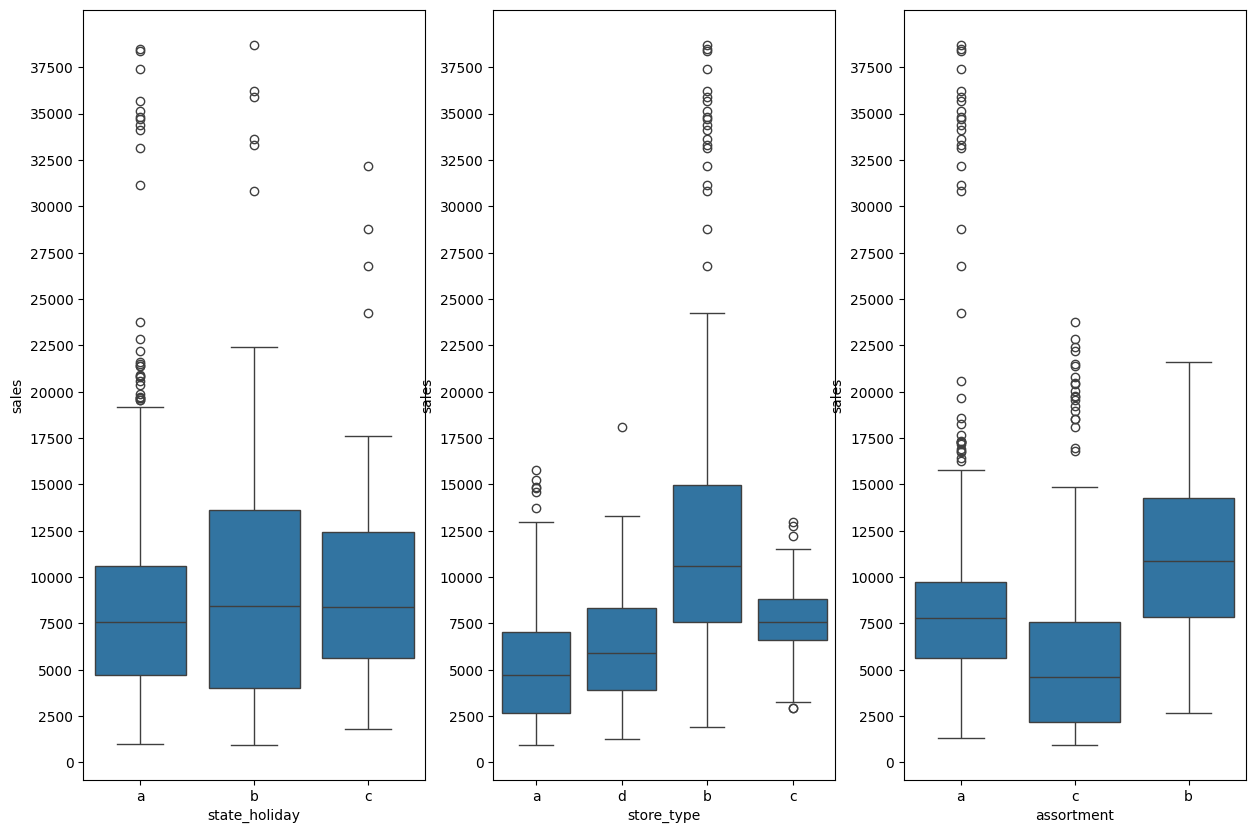

In [17]:
# filtering df1 to plot the graph
aux1 = df1.loc[ (df1['state_holiday'] != '0') & (df1['sales'] > 0), : ]

# setting the size of the plots
plt.figure( figsize = ( 15,10 ) )

# plotting the boxplot to understand the dispersion of categorical variables in relation to sales
plt.subplot( 1 ,3 , 1 )
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1 )
plt.yticks(range(0 , aux1['sales'].max(), 2500))

plt.subplot( 1, 3 , 2 )
sns.boxplot( x = 'store_type', y = 'sales', data = aux1 )
plt.yticks(range(0 , aux1['sales'].max(), 2500))

plt.subplot( 1, 3 , 3 )
sns.boxplot( x = 'assortment', y = 'sales', data = aux1 )
plt.yticks(range(0 , aux1['sales'].max(), 2500));

# 2.0. PASSO 2 - HYPOTHESIS ANDFEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1 Hypothesis

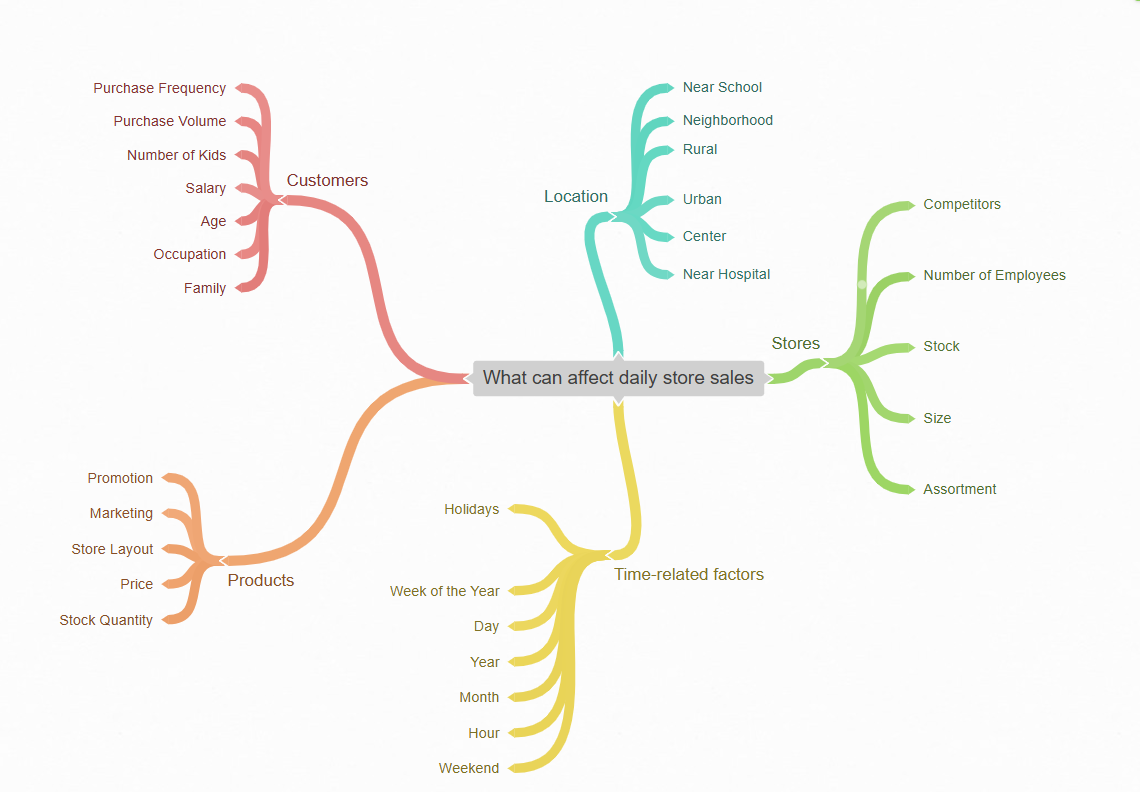

In [19]:
Image( r'img/mind_map.hypothesis.png' )

## 2.1.1. Store Hypotheses

**1.** Stores with a larger number of employees should sell more.

**2.** Stores with greater stock capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a wider assortment should sell more.

**5.** Stores with competitors nearby should sell less.

**6.** Stores with competitors for a longer period should sell more.

## 2.1.2. Product Hypotheses

**1.** Stores that invest more in marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower-priced products should sell more.

**5.** Stores with more aggressive promotions (larger discounts) should sell more.

**6.** Stores with longer-lasting promotions should sell more.

**7.** Stores with more days of promotion should sell more.

**8.** Stores with more consecutive promotions should sell more.

## 2.1.3 Time Hypotheses

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.


## 2.2. Final List of Hypotheses

**1.** Stores with a wider assortment should sell more.

**2.** Stores with competitors nearby should sell less.

**3.** Stores with competitors for a longer period should sell more.

**4.** Stores with longer-lasting promotions should sell more.

**5.** Stores with more days of promotion should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.3. - Feauture Engineering

In [20]:
# features temporais

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#=======================================================================================================================#

# competition since - nova coluna que leva em consideração o ano e o mes da competição
df2['competition_since'] = df2.apply( lambda x: datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ) , axis= 1) 

# competition time month - Tempo de competição em meses
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

# promo since - Desde quando a promoção ativa
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x : datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta(  days = 7 ) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days ).astype( 'int64' )



# assortment
df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 STEP 3 - FEATURE FILTERING

In [21]:
df3 = df2.copy()

In [22]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. - Row Filtering



In [23]:
# filters the variables that will not be available at the time of prediction
df3 = df3.loc[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ), : ]

## 3.2. - Column Filtering

In [24]:
# filtering columns - the columns that will not be passed at the time of prediction. In this case, customers
cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map' ]

df3 = df3.drop( cols_drop, axis = 1  )

# 4.0. - STEP 04 - EXPLORATORY DATA ANALYSIS

In [25]:
df4 = df3.copy()

## 4.1. - Univariate Analysis

### 4.1.1 - Response Variable

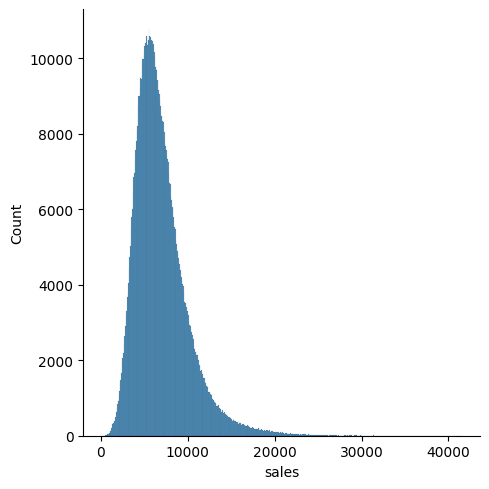

In [26]:
sns.displot( df4['sales'] ) 

### 4.1.2 - Numerical Variable

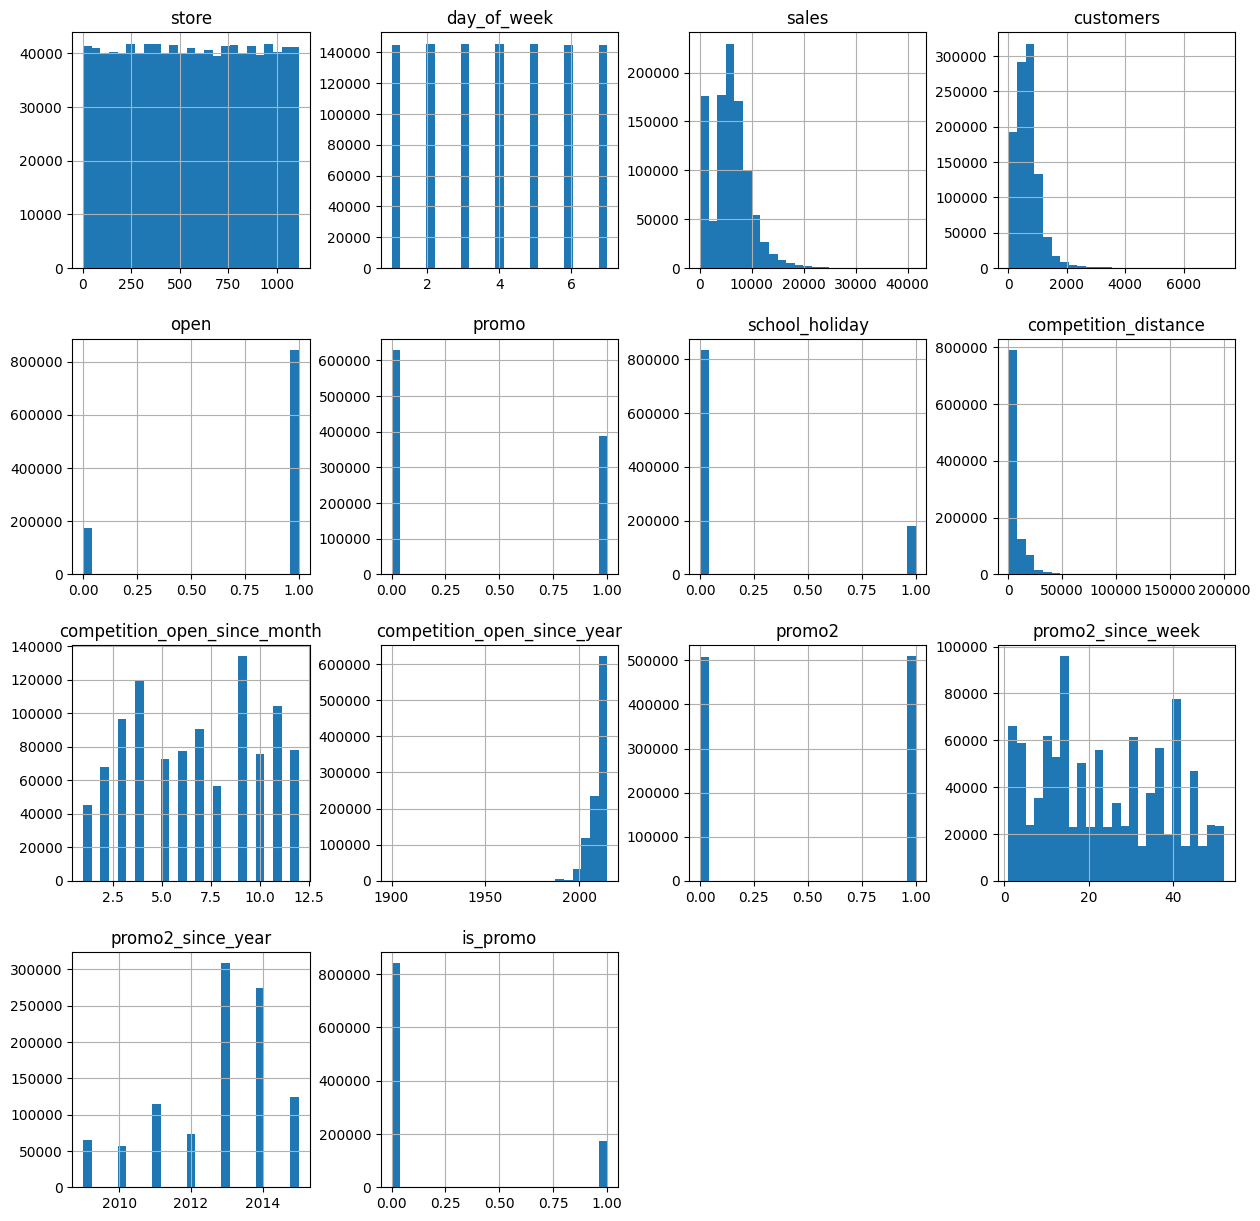

In [27]:
num_attributes.hist( bins = 25, figsize=( 15,15 ) );

### 4.1.3 - Categorical Variable

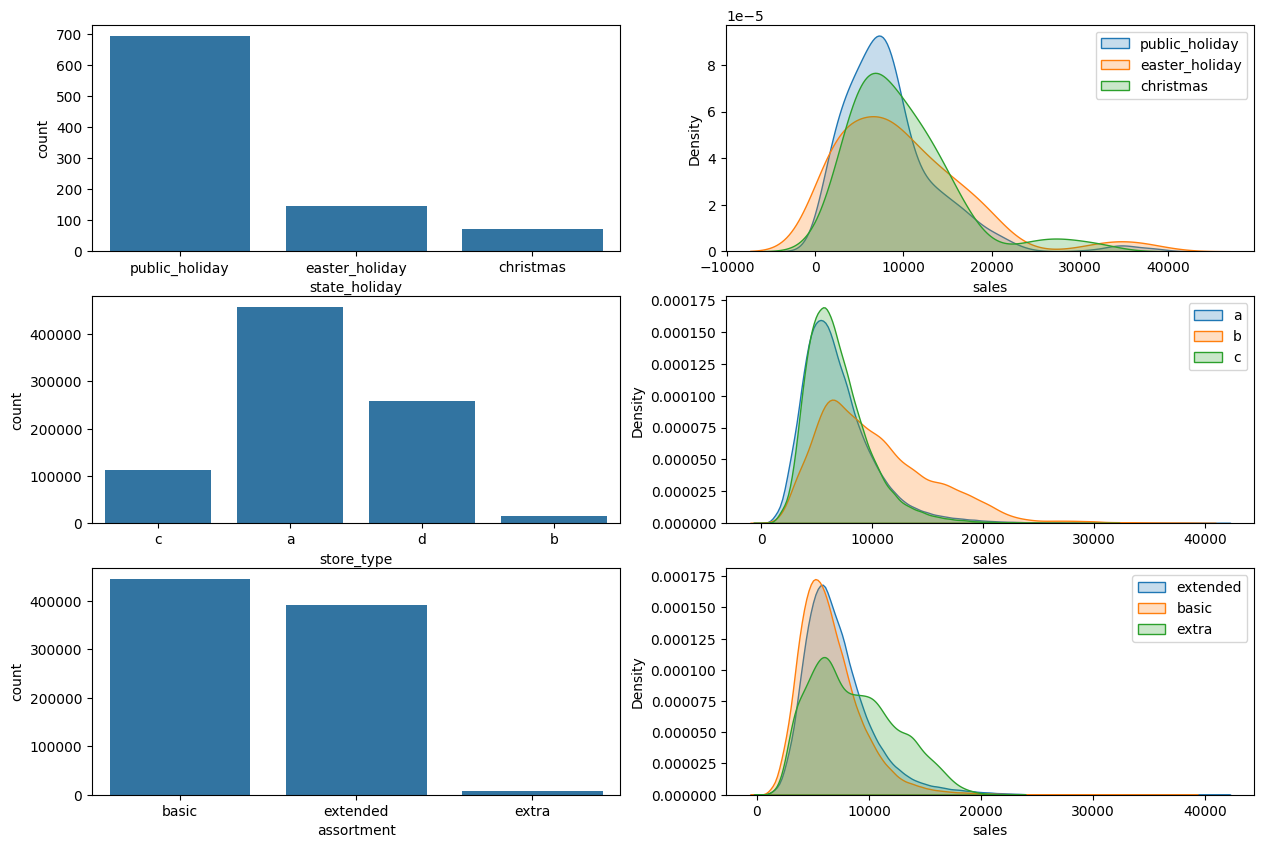

In [28]:
plt.figure( figsize = ( 15,10 ) )
plt.subplot( 3, 2 , 1 )
# filter the df by removing the regular_day
a = df4.loc[ df4['state_holiday'] != 'regular_day', : ]

# state_holiday
sns.countplot( a, x = 'state_holiday') 

# distribution of the state_holiday
plt.subplot( 3 , 2 , 2 )
sns.kdeplot( df4.loc[ df4['state_holiday'] == 'public_holiday', 'sales' ], label = 'public_holiday', fill = True )
sns.kdeplot( df4.loc[ df4['state_holiday'] == 'easter_holiday', 'sales' ], label = 'easter_holiday', fill = True )
sns.kdeplot( df4.loc[ df4['state_holiday'] == 'christmas', 'sales' ], label = 'christmas', fill = True )
plt.legend()

# store_type
plt.subplot( 3, 2 , 3 )
sns.countplot( data = df4, x = 'store_type'  )

plt.subplot( 3, 2 , 4 )
sns.kdeplot( df4.loc[ df4['store_type'] == 'a', 'sales' ], label = 'a', fill = True )
sns.kdeplot( df4.loc[ df4['store_type'] == 'b', 'sales' ], label = 'b', fill = True )
sns.kdeplot( df4.loc[ df4['store_type'] == 'c', 'sales' ], label = 'c', fill = True )
plt.legend()

# assortment
plt.subplot( 3, 2 , 5 )
sns.countplot( data = df4 , x = 'assortment' )

plt.subplot( 3, 2 , 6 )
sns.kdeplot( df4.loc[ df4['assortment'] == 'extended', 'sales' ], label = 'extended', fill = True )
sns.kdeplot( df4.loc[ df4['assortment'] == 'basic', 'sales' ], label = 'basic', fill = True )
sns.kdeplot( df4.loc[ df4['assortment'] == 'extra', 'sales' ], label = 'extra', fill = True )
plt.legend()

## 4.2. - Bivariate Analysis

### **H1.** Stores with a wider assortment should sell more.
 - **False** Stores with a wider assortment sell less.


<Axes: xlabel='year_week'>

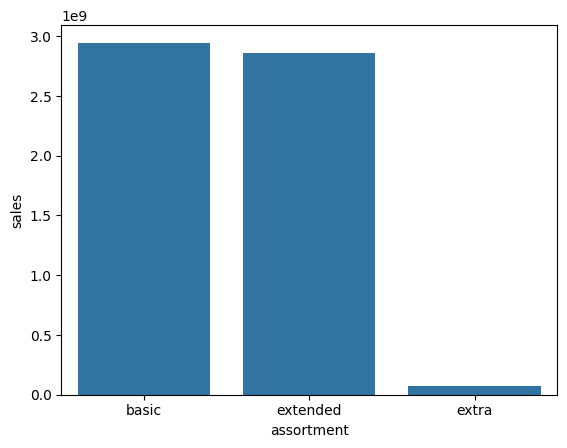

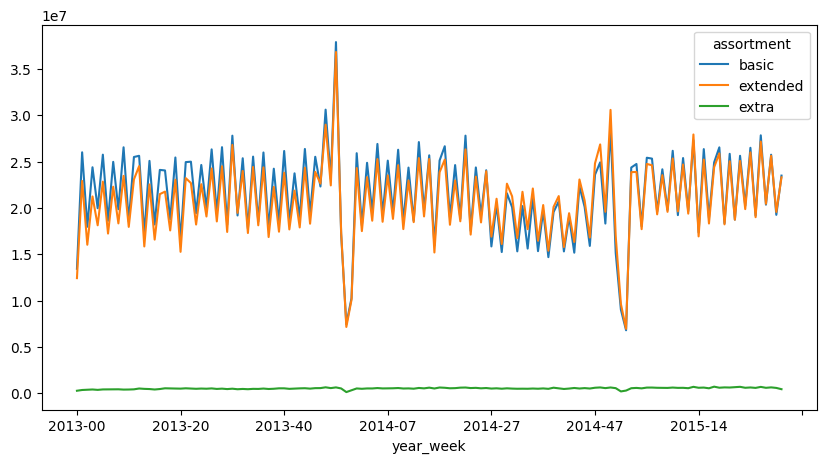

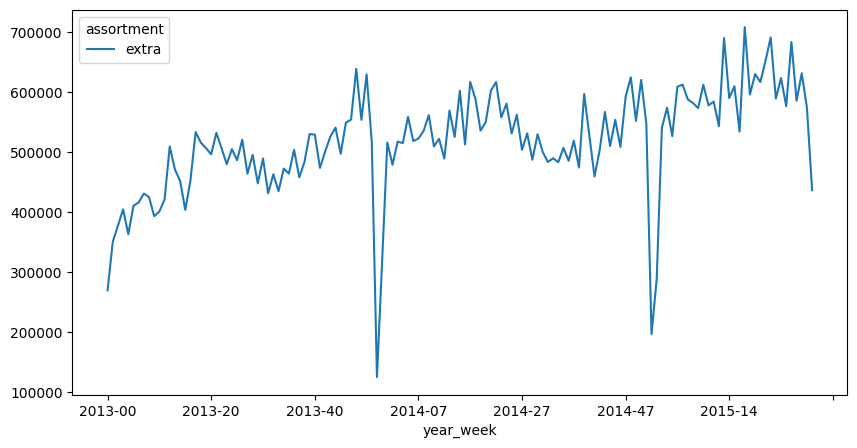

In [29]:
aux1 = df4[['sales','assortment']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x = 'assortment', y = 'sales', data = aux1 )


# analyze over time with the weeks of the year
aux2 = df4[['sales','assortment','year_week']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot(figsize=(10,5))

# analyzing only the extra sales over the weeks of the year
aux3 = aux2.loc[ aux2['assortment'] == 'extra', : ]
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot(figsize=(10,5))


### **H2.** Stores with competitors nearby should sell less.
- **False** Stores with competitors nearby sell more.

C:\Users\oscar\AppData\Local\Temp\ipykernel_15380\787691372.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned','sales']].groupby( 'competition_distance_binned' ).sum().reset_index()


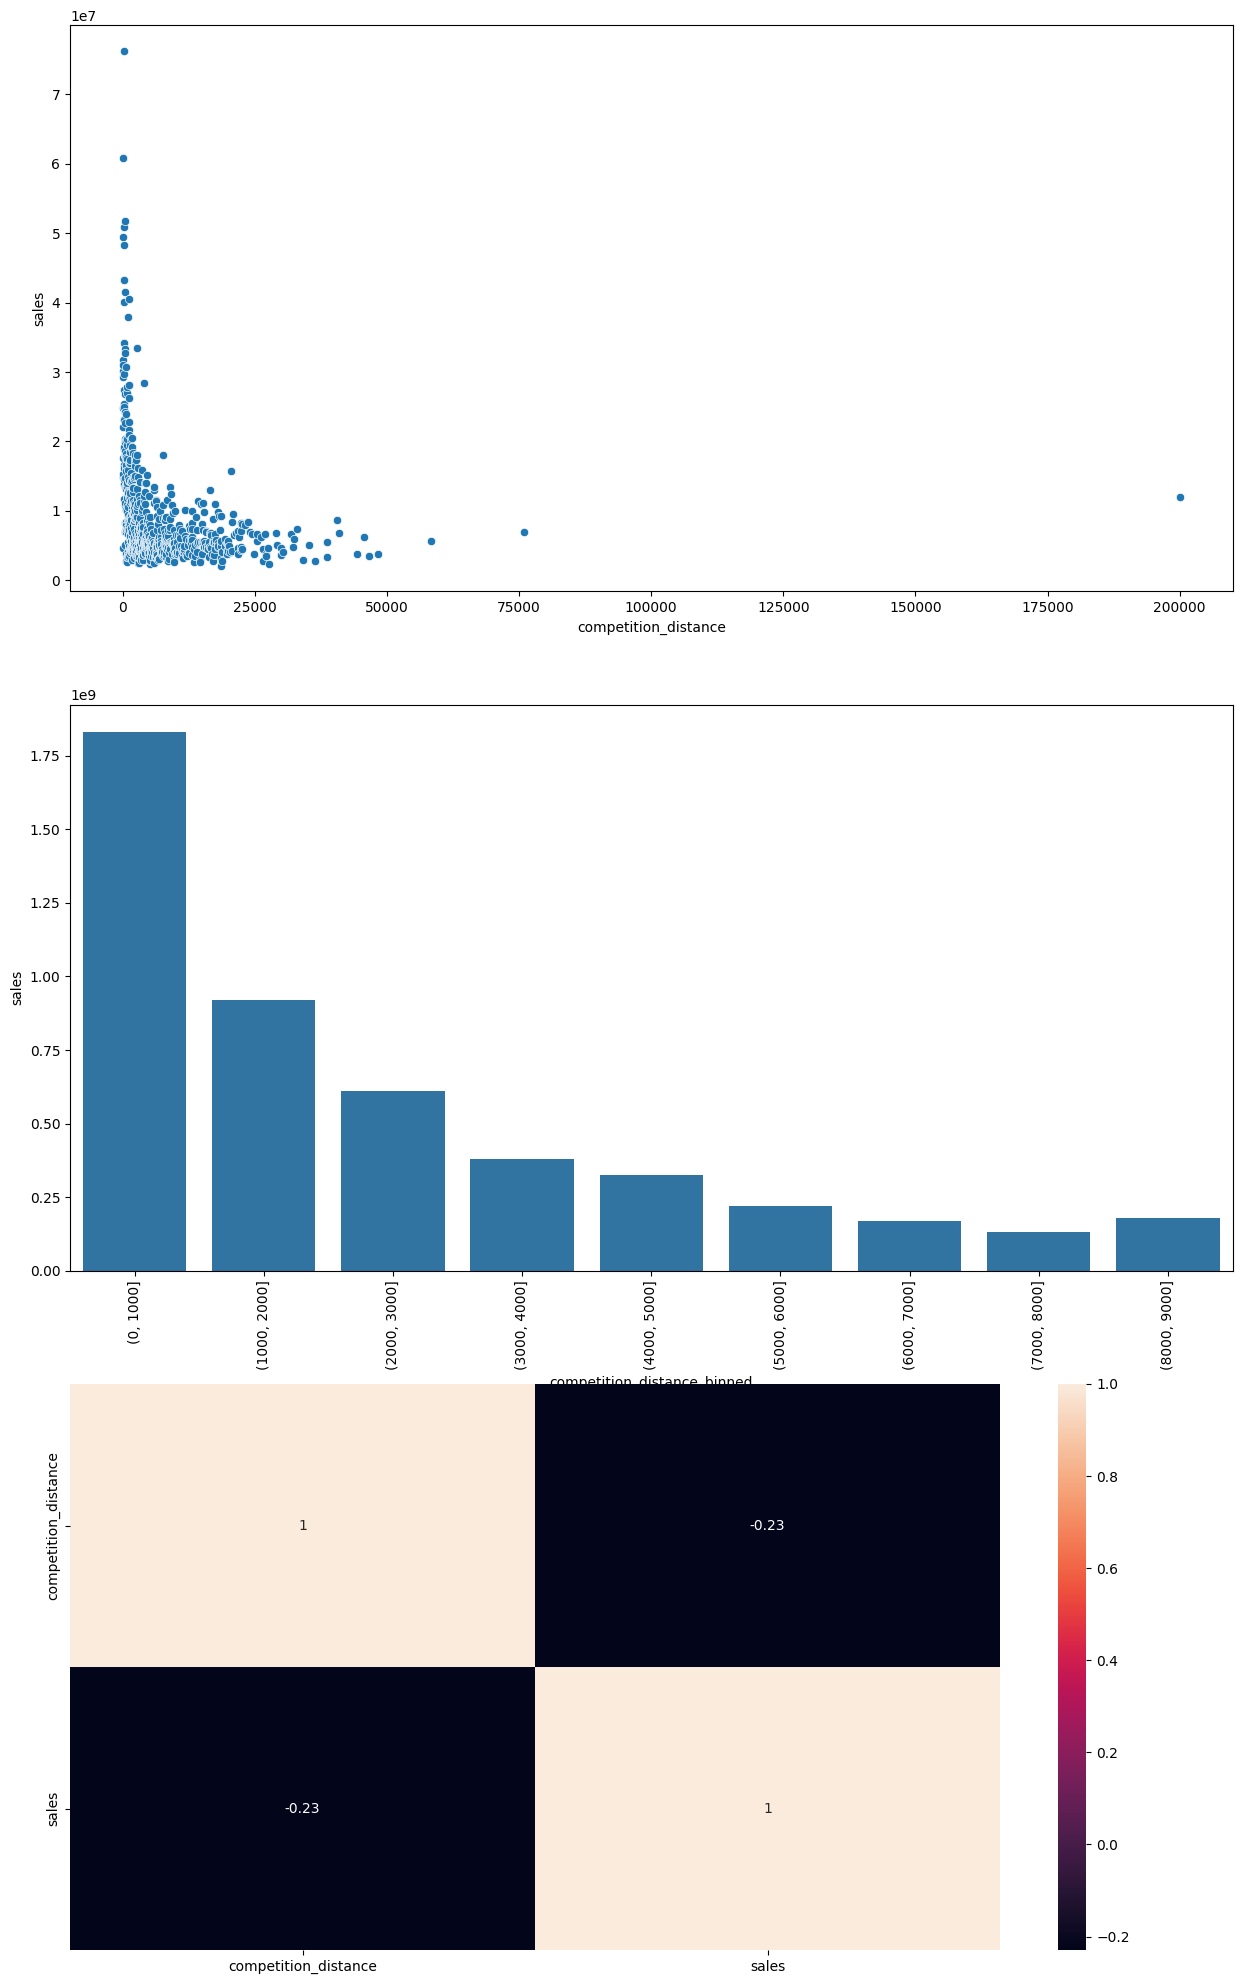

In [30]:
plt.figure( figsize = (15,25) )
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance' ).sum().reset_index()# select the required columns

# scatterplot
plt.subplot( 3,1,1 )
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1 )

bins = np.arange( 0, 10000, 1000 )# create the bins to plot the barplot

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )# create a new column with the bins

aux2 = aux1[['competition_distance_binned','sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

# barplot
plt.subplot( 3,1,2 )
# define and plot the bar chart
sns.barplot( x = 'competition_distance_binned', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 )

# heatmap
plt.subplot( 3,1,3)
x = sns.heatmap( aux1[['competition_distance', 'sales']].corr( method = 'pearson' ), annot = True )


### **H3**. Stores with competitors for a longer period should sell more.
- **False** Stores with competitors for a longer period sell less.

<Axes: >

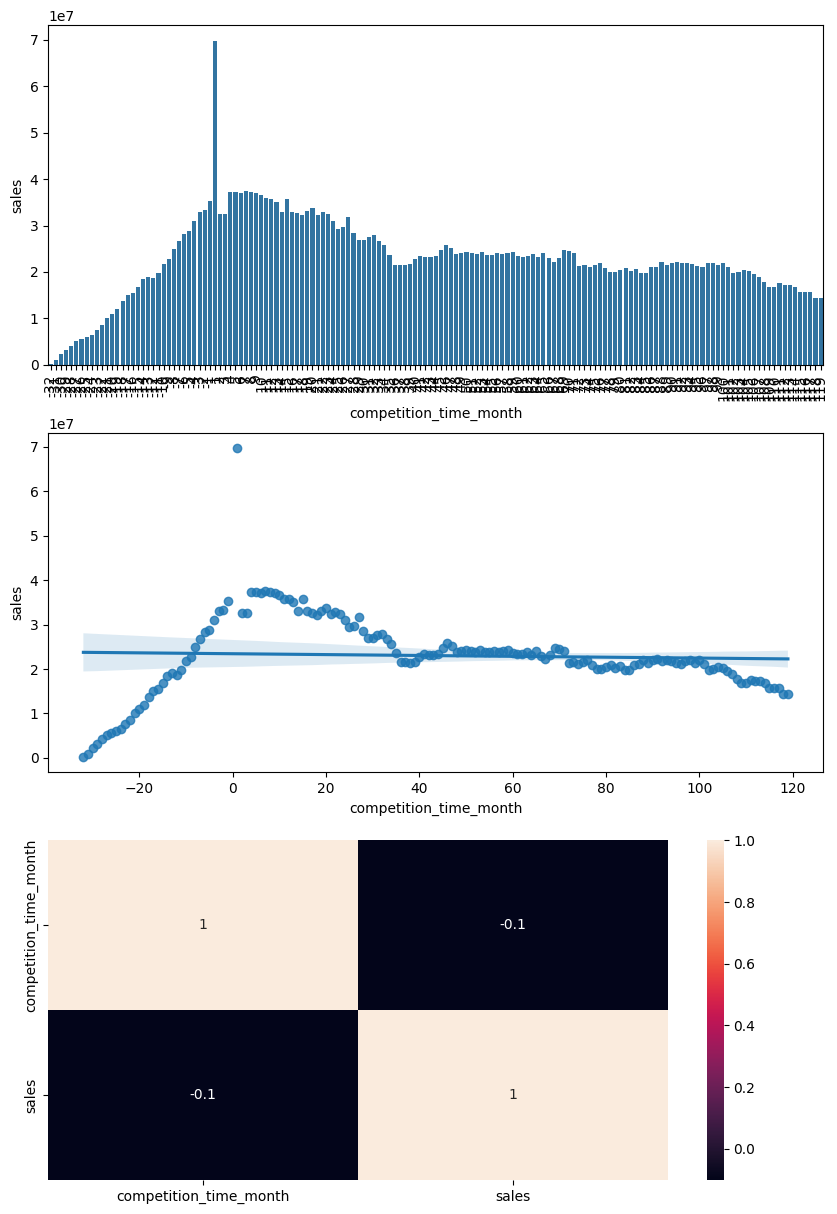

In [31]:
plt.figure( figsize= (10,15) )

# barplot
plt.subplot( 3,1,1 )
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1.loc[(aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) , :]
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 );

# regplot
plt.subplot( 3,1,2 )
sns.regplot( x = 'competition_time_month', y = 'sales', data = aux2 )

# heatmap
plt.subplot( 3,1,3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

### **H4.** Stores with longer-lasting promotions should sell more.
 - **False** Because stores with longer-lasting promotions sell less after a certain period of promotion.


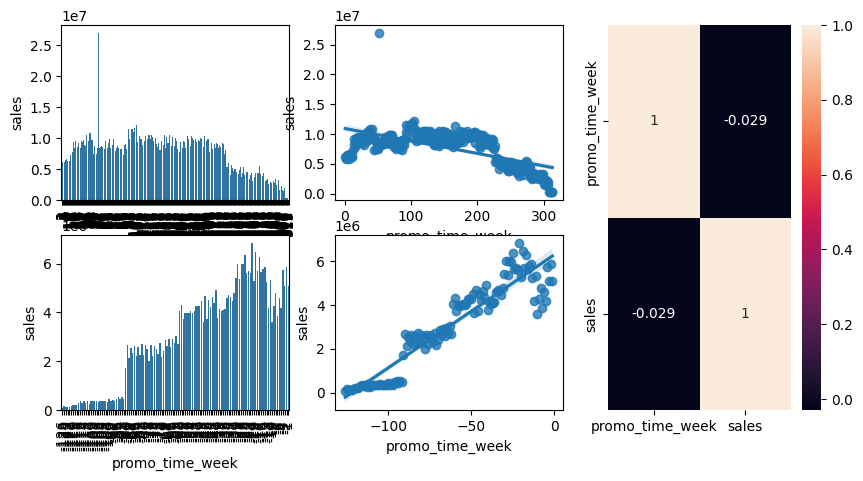

In [32]:
plt.figure(figsize = (10,5)) # set the size of the chart
aux1 = df4[['promo_time_week','sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2,3 )

plt.subplot( grid[ 0 , 0 ] )
aux2 = aux1.loc[ aux1['promo_time_week'] > 0 , : ]# extended promotion
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2 );
plt.xticks( rotation = 90 );

plt.subplot( grid[0,1] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2 );

plt.subplot( grid[ 1,0 ] )
aux3 = aux1.loc[ aux1['promo_time_week'] < 0  ] # regular promotion
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks( rotation = 90 );

plt.subplot( grid[ 1,1 ] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( 'pearson' ), annot = True );

### <s>**H5.** Stores with more days of promotion should sell more.</s> It will be for a future cycle


### **H6.** Stores with more consecutive promotions should sell more.
 - **False** Stores with more consecutive promotions sell less.


In [33]:
df4[['promo','promo2','sales']].groupby( ['promo','promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


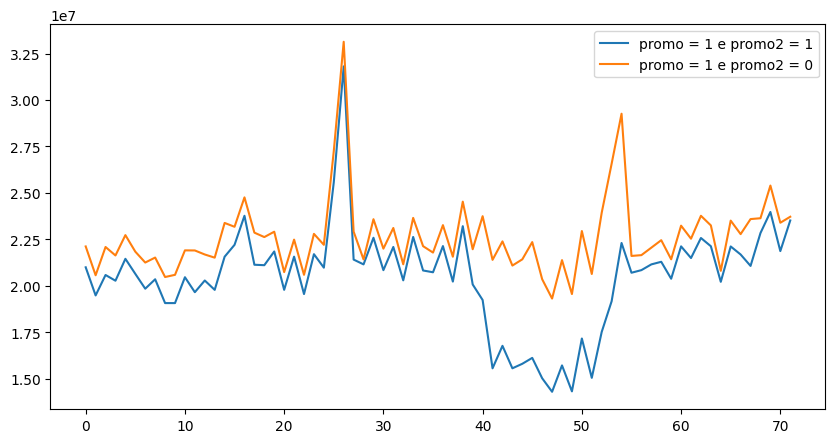

In [34]:
# stores that participated in both traditional and extended promotions
aux1 = df4.loc[ (df4['promo'] == 1) & ( df4['promo2'] == 1 ), ['year_week','sales'] ].groupby('year_week').sum().reset_index()
ax = aux1.plot();

# stores that only had the extended traditional period
aux2 =df4.loc[ (df4['promo'] == 1) & (df4['promo2'] == 0), ['year_week','sales'] ].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax = ax, figsize = (10,5) );

ax.legend( labels = [ 'promo = 1 e promo2 = 1', 'promo = 1 e promo2 = 0' ] );

### **H7.** Stores open during the Christmas holiday should sell more.
 - **False** Stores sell less during the Christmas holiday.



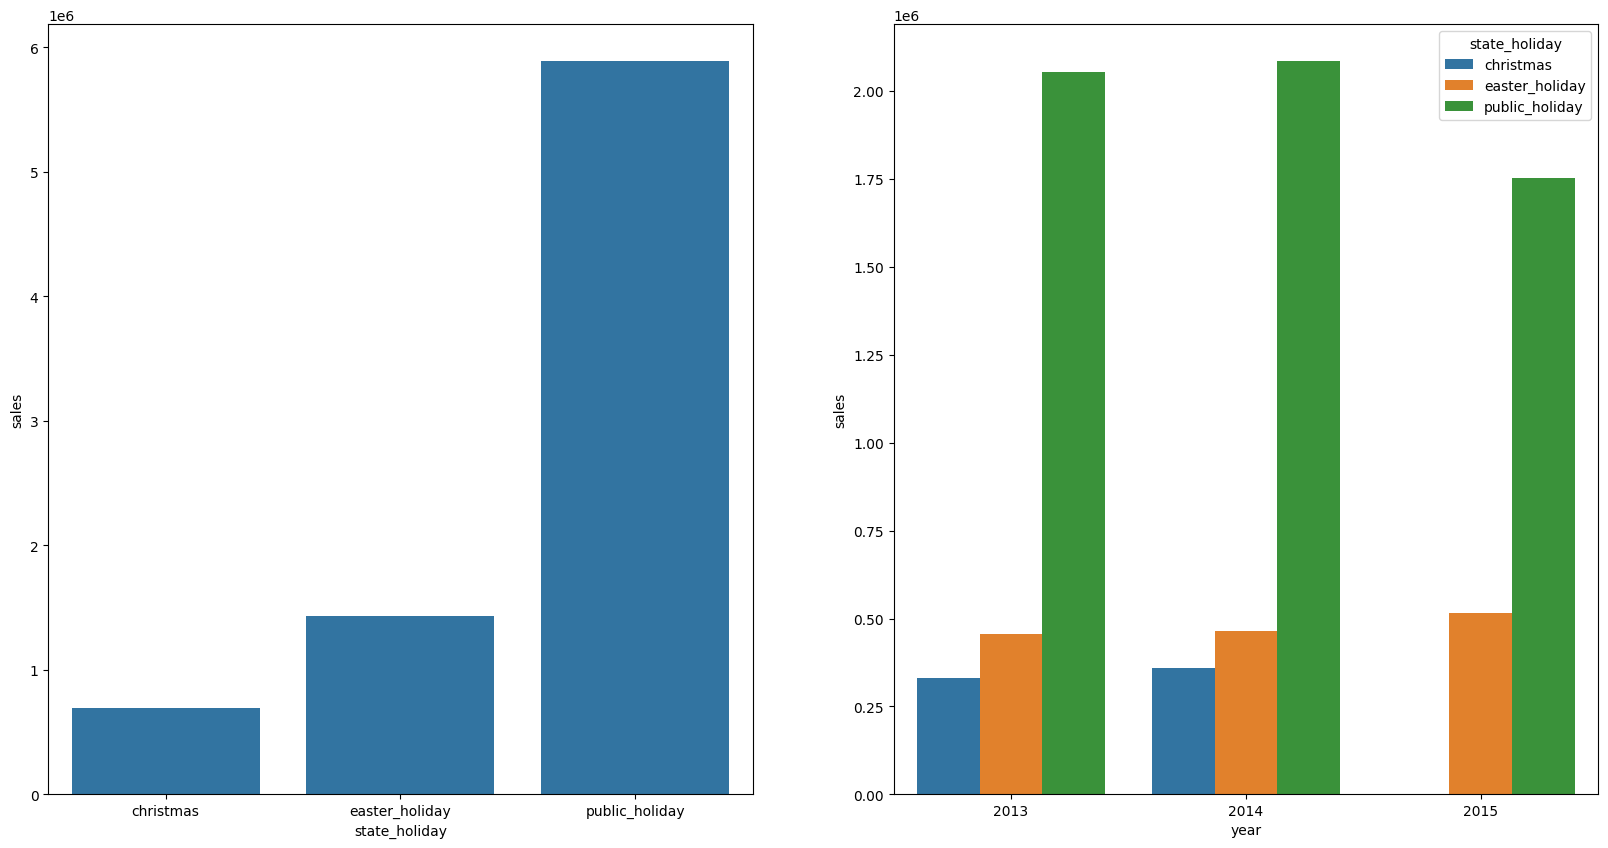

In [35]:
plt.figure( figsize= (20,10) )
plt.subplot( 1,2,1 )
aux1 = df4[['state_holiday','sales']].groupby( 'state_holiday' ).sum().reset_index()
aux1 = aux1.loc[ aux1['state_holiday'] != 'regular_day', : ]
sns.barplot( x = 'state_holiday', y = 'sales', data = aux1 );

# check if Christmas holiday sales were higher in any year
plt.subplot( 1,2,2, )
aux2 = df4[['year','state_holiday','sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
aux2 = aux2.loc[ aux2['state_holiday'] != 'regular_day', : ]
sns.barplot( x = 'year', y = 'sales', data = aux2 , hue = 'state_holiday' );

### **H8.** They should sell more over the years.
 - **False** Stores sell less over the years.


<Axes: >

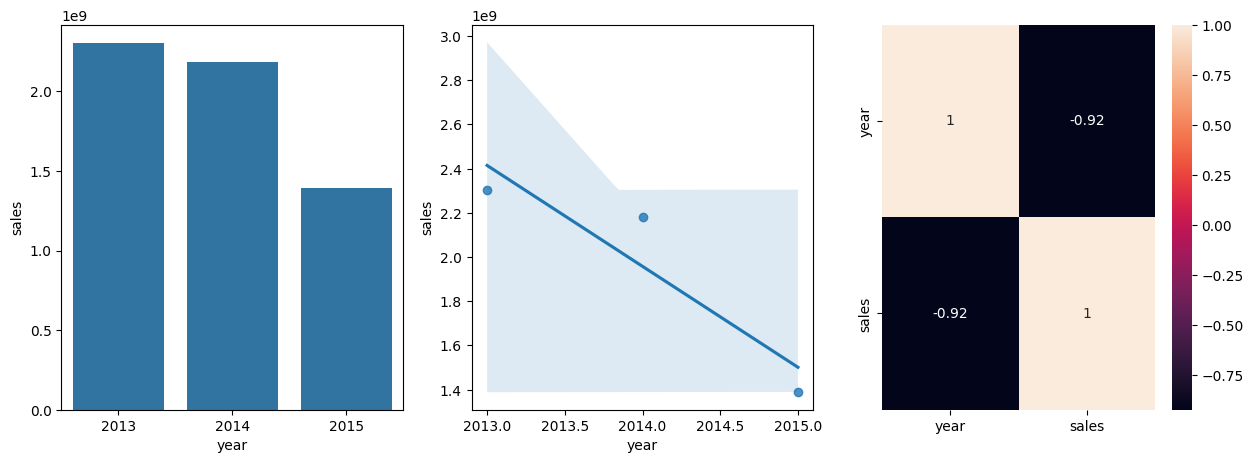

In [36]:
plt.figure( figsize= (15,5) )
plt.subplot( 1,3,1 )
aux1 = df4[['year','sales']].groupby( 'year' ).sum().reset_index()
sns.barplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x = 'year', y = 'sales', data = aux1 )

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method = 'pearson'), annot = True ) 

### **H9.** Stores should sell more in the second half of the year.
 - **False** Stores sell less in the second half of the year.


<Axes: >

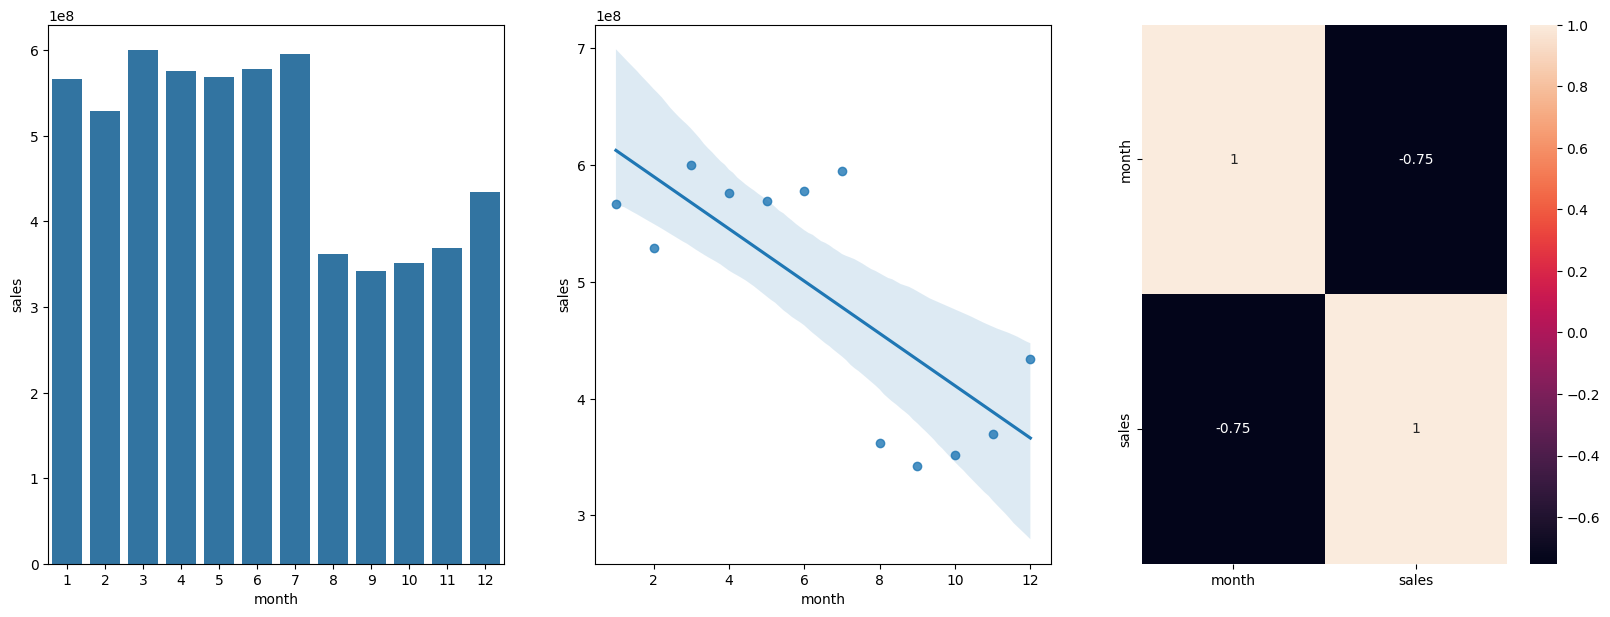

In [37]:
plt.figure( figsize = (20,7) )
aux1 = df4[['month','sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1,3,1 )
sns.barplot( x = 'month', y = 'sales', data = aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x = 'month', y = 'sales', data = aux1 )

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

### **H10.** Stores should sell more after the 10th of each month.
 - **True** Stores sell more after the 10th of each month.


<Axes: xlabel='before_after', ylabel='sales'>

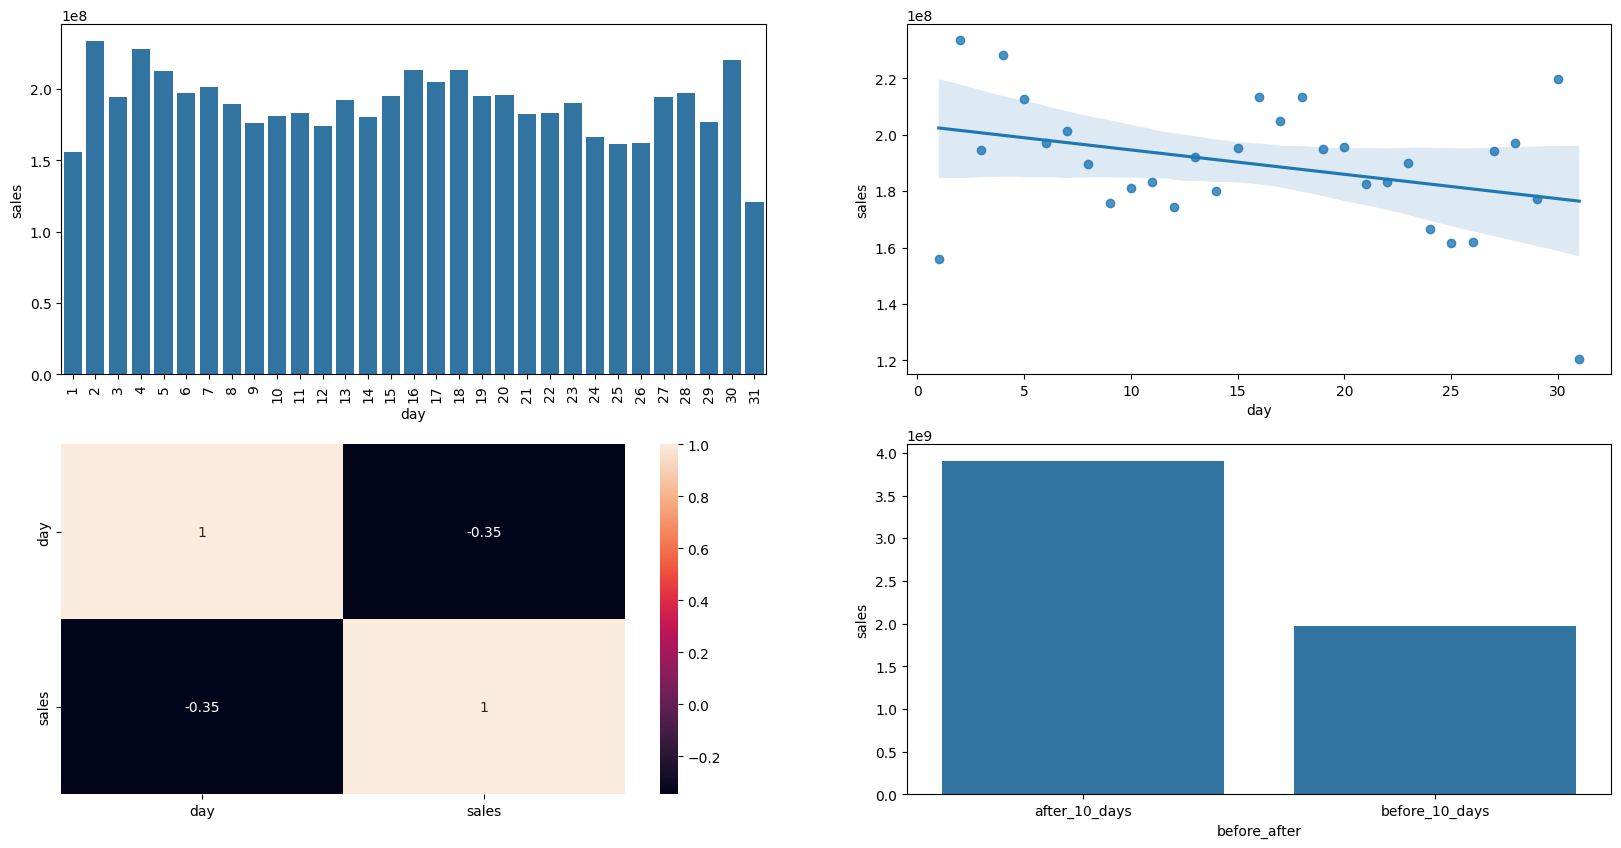

In [38]:
plt.figure( figsize = (20,10) )
plt.subplot( 2,2,1 )
aux1 = df4[['day','sales']].groupby( 'day' ).sum().reset_index()
sns.barplot( x = 'day', y = 'sales', data = aux1 );
plt.xticks( rotation = 90 )

plt.subplot( 2,2,2 )
sns.regplot( x= 'day', y = 'sales', data = aux1 )

plt.subplot( 2,2,3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

plt.subplot( 2,2,4 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after','sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data = aux2 )

### **H11.** Stores should sell less on weekends.
 - **True** Stores sell less on weekends.


<Axes: >

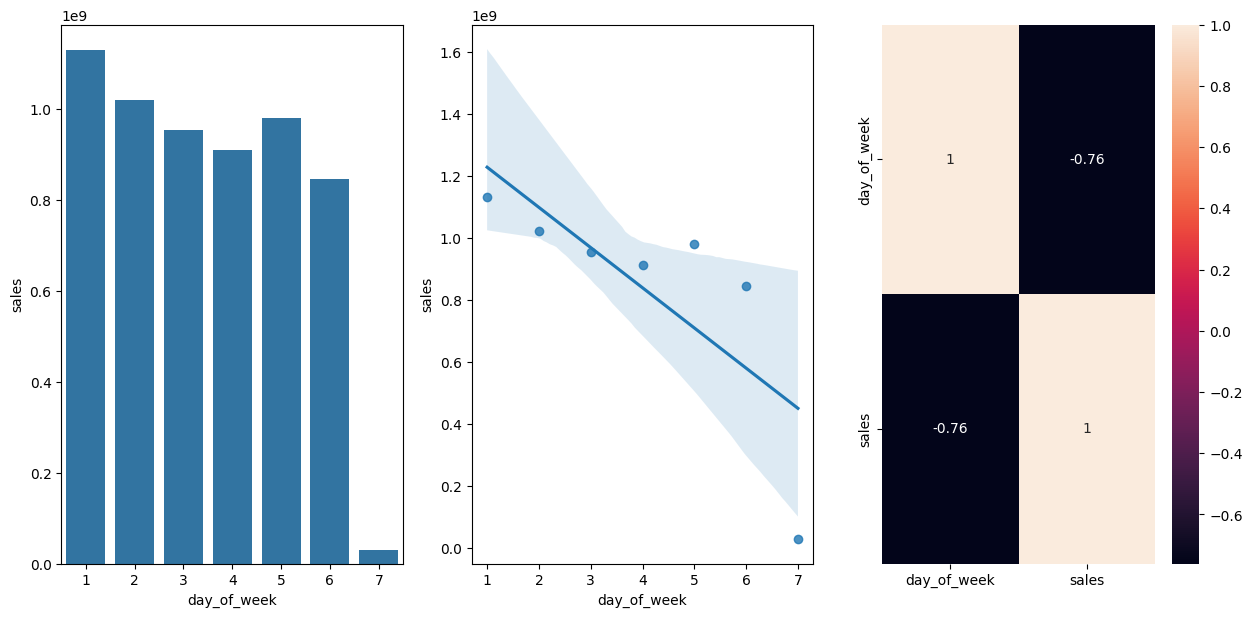

In [39]:
plt.figure( figsize=(15,7) )
plt.subplot( 1,3,1 )
aux1 = df4[['day_of_week','sales']].groupby( 'day_of_week' ).sum().reset_index()
sns.barplot( x ='day_of_week', y = 'sales', data = aux1 )

plt.subplot( 1,3,2 )
sns.regplot( x = 'day_of_week', y = 'sales', data = aux1 )

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True )

### **H12.** Stores should sell less during school holidays.
 - **True** Stores sell less during school holidays.


<Axes: xlabel='month', ylabel='sales'>

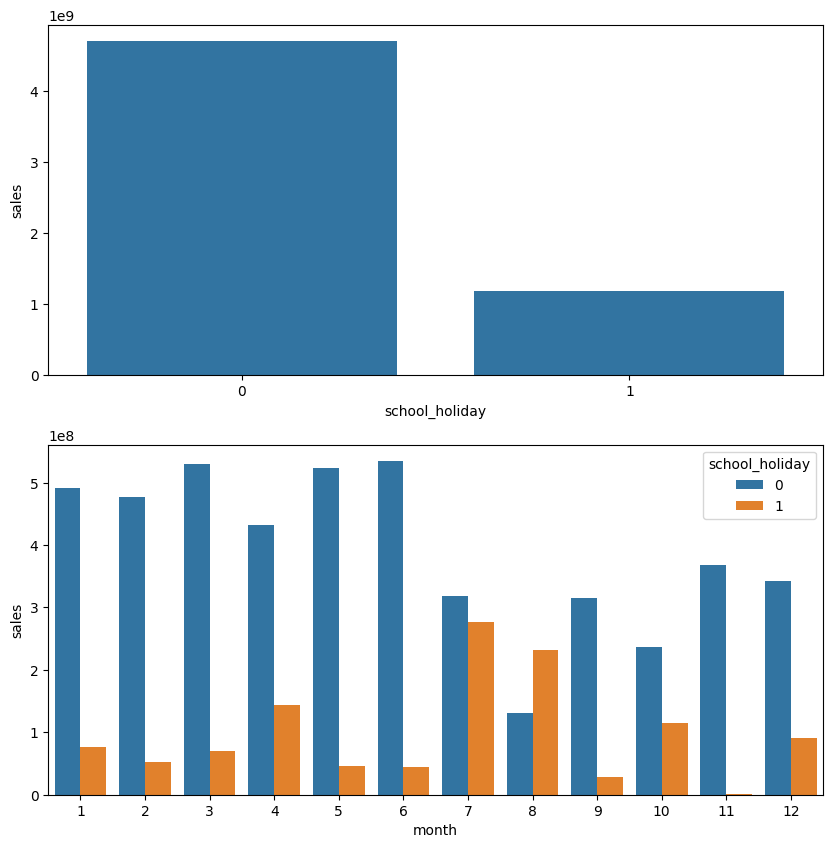

In [40]:
plt.figure( figsize = (10,10) )
plt.subplot( 2,1,1 )
aux1 = df4[['school_holiday','sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1  )

plt.subplot( 2,1,2 )
aux2 = df4[['month','school_holiday','sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', data = aux2, hue = 'school_holiday' )


### 4.2.1 Summary of Hypotheses

In [41]:
tab = [['Hypothesis', 'Conclusion', 'Relevance to the model'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']
]
print(tabulate(tab, headers='firstrow'))


Hypothesis    Conclusion    Relevance to the model
------------  ------------  ------------------------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3. - Multivariate Analysis

### 4.3.1 - Numerical Attributes

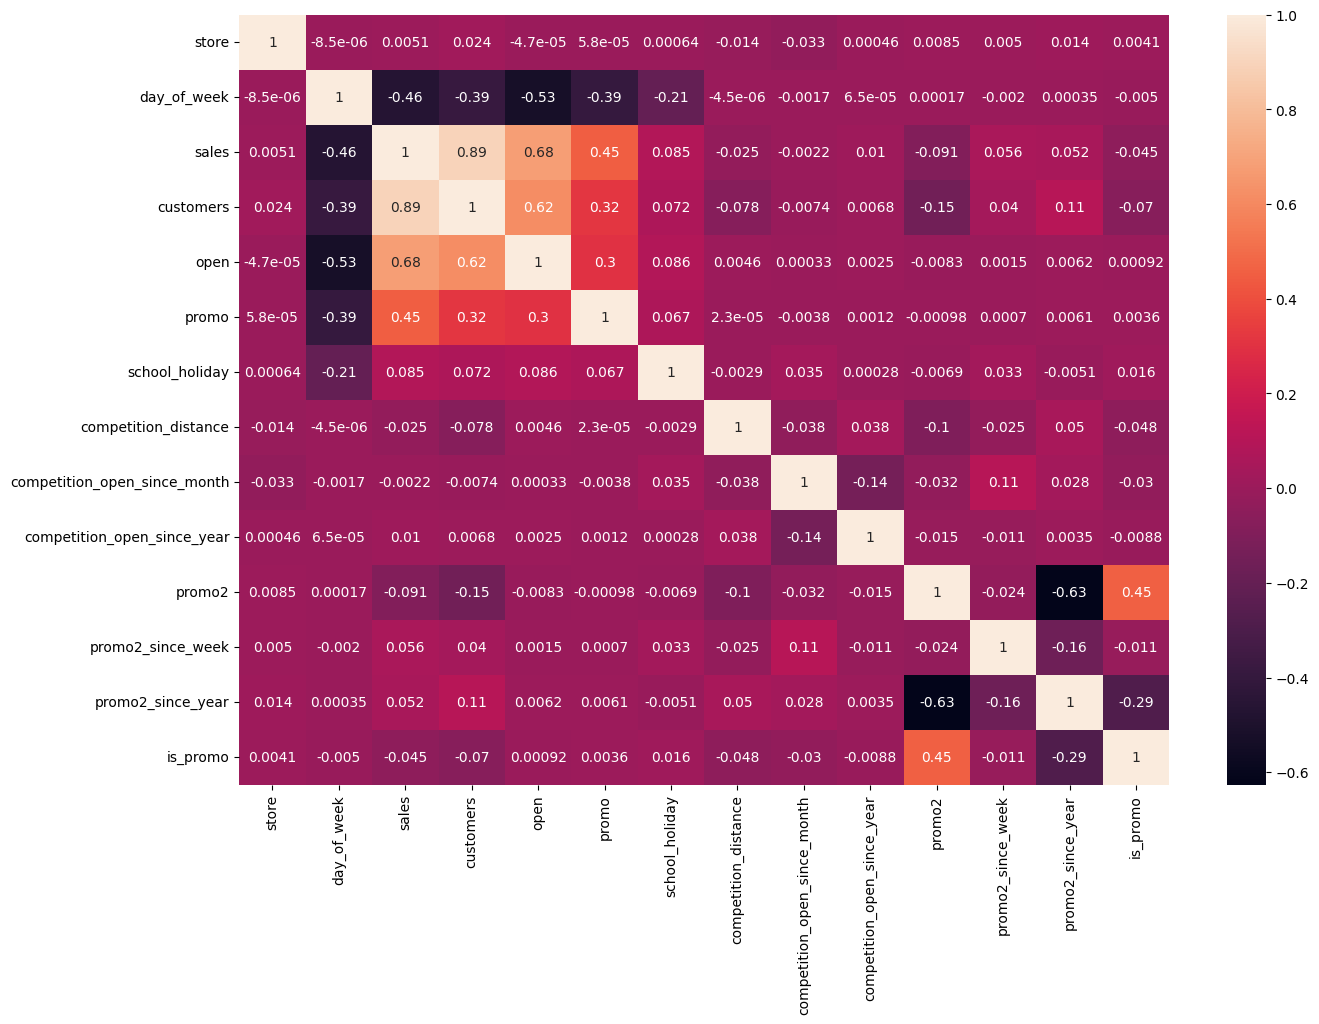

In [42]:
plt.figure( figsize = (15,10) )
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

### 4.3.2 - Categorical Attributes

In [43]:
a = df4.select_dtypes( include = ['object'] ) # get the most up-to-date df

In [44]:
# apply the Cramér's V function on the categorical variables
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday' : [a1,a2,a3],
               'store_type' : [a4,a5,a6],
               'assortment' : [a7,a8,a9]
              
              } )

d = d.set_index( d.columns )


<Axes: >

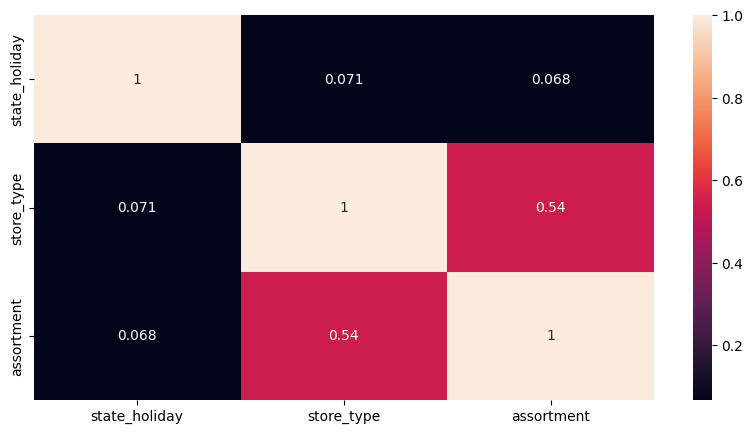

In [45]:
# check the correlation between the variables
plt.figure( figsize = (10,5) )
sns.heatmap( d, annot = True )

# 5.0. - STEP 05 - DATA PREPARATION

In [46]:
df5 = df4.copy()

## 5.1. - Z-SCORE Normalization

### Works well for variables with a normal distribution. In my case, I don't have variables with a normal distribution.

## 5.2. - Rescaling

In [47]:
# used for variables that do not have a normal distribution
a = df5.select_dtypes( include = ['float64','int64'] )

In [48]:
rs = RobustScaler() # used for variables that have outliers
mms = MinMaxScaler() # used for variables that do not have outliers
# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl' , 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs , open( 'parameter/competition_time_month_scaler.pkl' , 'wb' ) )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )

## 5.3. - Transformation

### 5.3.1 - Encoding

In [49]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies( df5 , prefix = 'state_holiday', columns = ['state_holiday'] )

# store_type - Labelencoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl' , 'wb' ) )

# assorment - ordinal encoding
assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 - Response Variable Transformation

In [50]:
df5['sales'] = np.log1p( df5['sales'] )

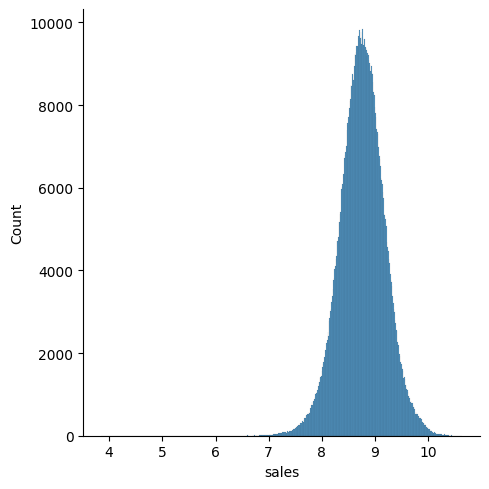

In [51]:
sns.displot( df5['sales'] )

### 5.3.3 Nature Transformation

In [52]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi / 7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi / 7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x : np.sin( x * ( 2. * np.pi / 30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x : np.cos( x * (2. * np.pi / 30) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 )  ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi / 52 ) ) )

# 6.0. - STEP 06 - FEATURE SELECTION

In [53]:
df6 = df5.copy()

## 6.1. - Split dataset into training and Test dataset

In [54]:
# create a list with the columns from which I derived the variables (otherwise they will be duplicated)
cols_drop = ['week_of_year','day','month','day_of_week','promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis = 1 )

In [55]:
# calculate the minimum date per store
df6[['date','store']].groupby( 'store' ).min().reset_index()['date'][2] # get minimum date

# check the maximum date and subtract 6 weeks
df6[['date','store']].groupby( 'store' ).max().reset_index()['date'][2] - timedelta( days = 6*7) 

# training dataset
X_train = df6.loc[ df6['date'] < '2015-06-19', : ] 
y_train = X_train['sales']

# test dataset
X_test = df6.loc[ df6['date'] >= '2015-06-19', : ] # last six weeks of the dataset
y_test = X_test['sales']

print( 'Training Min Date {} '.format( X_train['date'].min() ) )
print( 'Training Max Date {}'.format( X_train['date'].max() ) )

print( '='*100 )

print( 'Test Min Date {}'.format( X_test['date'].min() ) )
print( 'Test Max Date {}'.format( X_test['date'].max() ) )


Training Min Date 2013-01-01 00:00:00 
Training Max Date 2015-06-18 00:00:00
Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.2. - Boruta as Feature Selector

In [ ]:
# training and test dataset for boruta
X_train_n = X_train.drop( ['sales' , 'date'] , axis= 1 ).values
y_train_n = y_train.values.ravel()

# Rf instance
rf = RandomForestRegressor( n_jobs = -1 )

# apply Boruta
boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train_n, y_train_n )

# get the columns and store them in the variable
cols_selected = boruta.support_.tolist()

# df boruta
df_boruta = df6.loc[ : , cols_selected]

In [ ]:
# list with the columns (bool)
cols_selected = boruta.support_.tolist()

# boruta selected columns
X_train_fs = X_train.drop( ['sales','date'], axis = 1 )
cols_selected_boruta = X_train_fs.loc[ : , cols_selected ]

# boruta not selected cols 
cols_not_selected = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta.columns ) )

## 6.3. - Manual Feature Selection

In [56]:
# selected columns
cols_selected_boruta = ['store', 
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']

# columns to add
feat_to_add = ['date','sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

## 7.0. - STEP 07 - MACHINE LEARNING MODELLING

In [68]:
# training data
x_train = X_train[ cols_selected_boruta ]

# test data
x_test = X_test[ cols_selected_boruta ]

In [69]:
# defining the x_training - includes the 'date' and 'sales' columns used for cross-validation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. - Average Model 

In [70]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction 
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales': 'prediction'} )
aux1 = pd.merge( aux1, aux2 , how = 'left', on = 'store' )
y_hat_baseline = aux1['prediction']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ) , np.expm1( y_hat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. - Linear Regression Model

In [71]:
# model
lr = LinearRegression().fit( x_train , y_train )

# prediction
y_hat_lr = lr.predict( x_test )

# performance 
lr_result = ml_error( 'Linear Regression Model', np.expm1(  y_test  ) , np.expm1( y_hat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,1867.089774,0.292694,2671.049215


## 7.2.1 - Linear Regression Model - Cross Validation

In [72]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression Cv', lr , verbose = False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Cv,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. - Linear Regression Regularized Model - Lasso

In [73]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train , y_train )

# prediction
y_hat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Lasso', np.expm1( y_test ) , np.expm1( y_hat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.704881,0.289106,2744.451737


## 7.3.1 - Linear Regression Regularized Model - Lasso - CV

In [74]:
lasso_cv = cross_validation( x_training, 5, 'Lasso Cv', lrr, verbose = False )
lasso_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso Cv,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. - Random Forest Regressor

In [75]:
# model
rf = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42  ).fit( x_train , y_train )

# prediction
y_hat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ) , np.expm1( y_hat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.455795,0.099667,1007.9169


## 7.4.1 - Random Forest Regressor - CV 

In [76]:
rf_cv = cross_validation( x_training, 5, 'Random Forest Regressor Cv', rf, verbose = True )
rf_cv


 kfold number5

 kfold number4

 kfold number3

 kfold number2

 kfold number1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor Cv,838.23 +/- 218.1,0.12 +/- 0.02,1257.07 +/- 318.2


## 7.5. - XGBoost Regressor 

In [77]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit( x_train , y_train )

# prediction
y_hat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ) , np.expm1( y_hat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1684.097319,0.249984,2462.466879


## 7.5.1 - XGBoost Regressor - CV 

In [78]:
xgb_cv = cross_validation( x_training, 5, 'XGBoost Regressor Cv', model_xgb , verbose = False )
xgb_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor Cv,1856.55 +/- 287.91,0.25 +/- 0.01,2684.24 +/- 429.81


## 7.6. - Compare Model's Performance

## 7.6.1 - Single Performance

In [79]:
modelling_result = pd.concat( [baseline_result,lr_result,lrr_result,rf_result,xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.455795,0.099667,1007.916900
0,Average Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1684.097319,0.249984,2462.466879
0,Linear Regression Model,1867.089774,0.292694,2671.049215
0,Lasso,1891.704881,0.289106,2744.451737


## 7.6.2 - Real Performance

In [80]:
modelling_result_cv = pd.concat( [lr_result_cv,lasso_cv,rf_cv, xgb_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )  

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor Cv,838.23 +/- 218.1,0.12 +/- 0.02,1257.07 +/- 318.2
0,XGBoost Regressor Cv,1856.55 +/- 287.91,0.25 +/- 0.01,2684.24 +/- 429.81
0,Linear Regression Cv,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso Cv,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0. - PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. - Random Search

In [81]:
param = {'n_estimators' : [15,17,25,30,35],
         'eta' : [0.01,0.03],
         'max_depth' : [3,5,9],
         'subsample' : [0.1,0.5,0.7],
         'colsample_mbytree' : [0.3,0.7,0.9],
         'min_child_weight' : [3,8,15]}

MAX_EVAL = 3

In [82]:
final_result = pd.DataFrame( )

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k : random.sample( v,1 )[0] for k,v in param.items()}
    print( hp )
    # model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                 n_estimators = hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytree = hp['colsample_mbytree'],
                                 min_child_weight = hp['min_child_weight'])
    # performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb , verbose=False)
    final_result = pd.concat( [final_result, result] )
    
final_result

{'n_estimators': 15, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_mbytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 15, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_mbytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 30, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_mbytree': 0.3, 'min_child_weight': 3}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,2332.33 +/- 133.85,0.32 +/- 0.01,3334.61 +/- 179.94
0,XGBoost Regressor,2332.91 +/- 134.2,0.32 +/- 0.01,3335.26 +/- 180.29
0,XGBoost Regressor,2187.46 +/- 112.55,0.3 +/- 0.01,3163.34 +/- 159.55


## 8.2. - Final Model

In [86]:
param_tuned = {'n_estimators' : 30 ,
         'eta' : 0.03 ,
         'max_depth' : 5 ,
         'subsample' : 0.5,
         'colsample_mbytree' : 0.3,
         'min_child_weight' : 3 }

In [87]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_mbytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit( x_train, y_train )
# prediction  
y_hat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test) , np.expm1(y_hat_xgb_tuned))

In [88]:
# add the MPE error to the final model table
xgb_result_tuned['MPE'] = mean_percentage_error(np.expm1 (y_test) ,np.expm1(y_hat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE,MPE
0,XGBoost Regressor,1987.741207,0.304755,2865.876982,-0.063916


# 9.0. - STEP 09 - Scenarios

In [89]:
df9 = X_test[ cols_selected_boruta_full ]

In [90]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9.loc[:,'predictions'] = np.expm1( y_hat_xgb_tuned )

C:\Users\oscar\AppData\Local\Temp\ipykernel_15380\1759580448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
C:\Users\oscar\AppData\Local\Temp\ipykernel_15380\1759580448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9.loc[:,'predictions'] = np.expm1( y_hat_xgb_tuned )


## 9.1. - Business Performance

In [91]:
# sum of predictions
df91 = df9[['store','predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions']) ).reset_index().rename( columns = {0:'MAE'} )
df9_aux2 = df9[['store','sales','predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])  ).reset_index().rename( columns = {0:'MAPE'} )

# merge dataframes
df9_aux3 = pd.merge( df9_aux1 , df9_aux2, how = 'inner', on = 'store' )
df92 = pd.merge( df91, df9_aux3, how = 'inner', on = 'store' )

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]
df92

C:\Users\oscar\AppData\Local\Temp\ipykernel_15380\3838736209.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df9_aux1 = df9[['store','sales','predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions']) ).reset_index().rename( columns = {0:'MAE'} )
C:\Users\oscar\AppData\Local\Temp\ipykernel_15380\3838736209.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df9

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,235142.640625,233174.461043,237110.820207,1968.179582,0.474425
1,2,224426.078125,223091.189348,225760.966902,1334.888777,0.342069
2,3,226950.125000,225670.285209,228229.964791,1279.839791,0.176851
3,4,245207.875000,241851.925728,248563.824272,3355.949272,0.322333
4,5,224050.875000,222415.969159,225685.780841,1634.905841,0.524685
...,...,...,...,...,...,...
1110,1111,223498.265625,221710.629263,225285.901987,1787.636362,0.472841
1111,1112,247493.390625,245466.554991,249520.226259,2026.835634,0.199293
1112,1113,252301.671875,251599.550636,253003.793114,702.121239,0.116450
1113,1114,253937.578125,238024.431654,269850.724596,15913.146471,0.694813


In [92]:
# lojas dificeis de prever - MAPE alto
df92.sort_values( 'MAPE', ascending = False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
542,543,238210.68750,234419.695999,242001.679001,3790.991501,1.787779
306,307,233183.78125,229523.841414,236843.721086,3659.939836,1.710384
197,198,201782.09375,199110.658863,204453.528637,2671.434887,1.592219
969,970,227542.00000,224172.972999,230911.027001,3369.027001,1.583972
840,841,221627.34375,218165.712759,225088.974741,3461.630991,1.570242


<Axes: xlabel='store', ylabel='MAPE'>

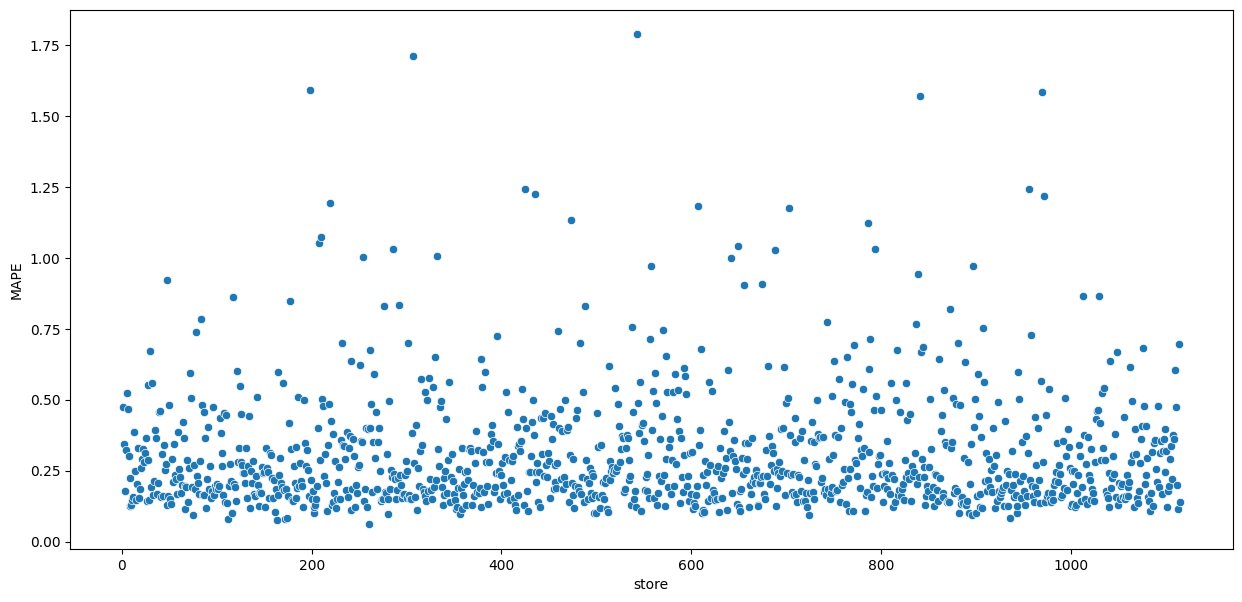

In [93]:
# mostrando de forma visual
plt.figure( figsize = (15,7) )
sns.scatterplot( x = 'store', y = 'MAPE', data = df92 )

## 9.2. - Total Performance

In [94]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply( lambda x: np.sum( x ), axis = 0 ).reset_index().rename( columns = {'index': 'scenario', 0 : 'values'} )
df93['values'] = df93['values'].map( '{:,.2f}'.format )
df93

,scenario,values
0,predictions,"264,048,992.00"
1,worst_scenario,"261,834,639.49"
2,best_scenario,"266,263,310.97"


## 9.3. - Machine Learning Performance

In [95]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\oscar\AppData\Local\Temp\ipykernel_15380\1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\oscar\AppData\Local\Temp\ipykernel_15380\1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


<Axes: xlabel='predictions', ylabel='error'>

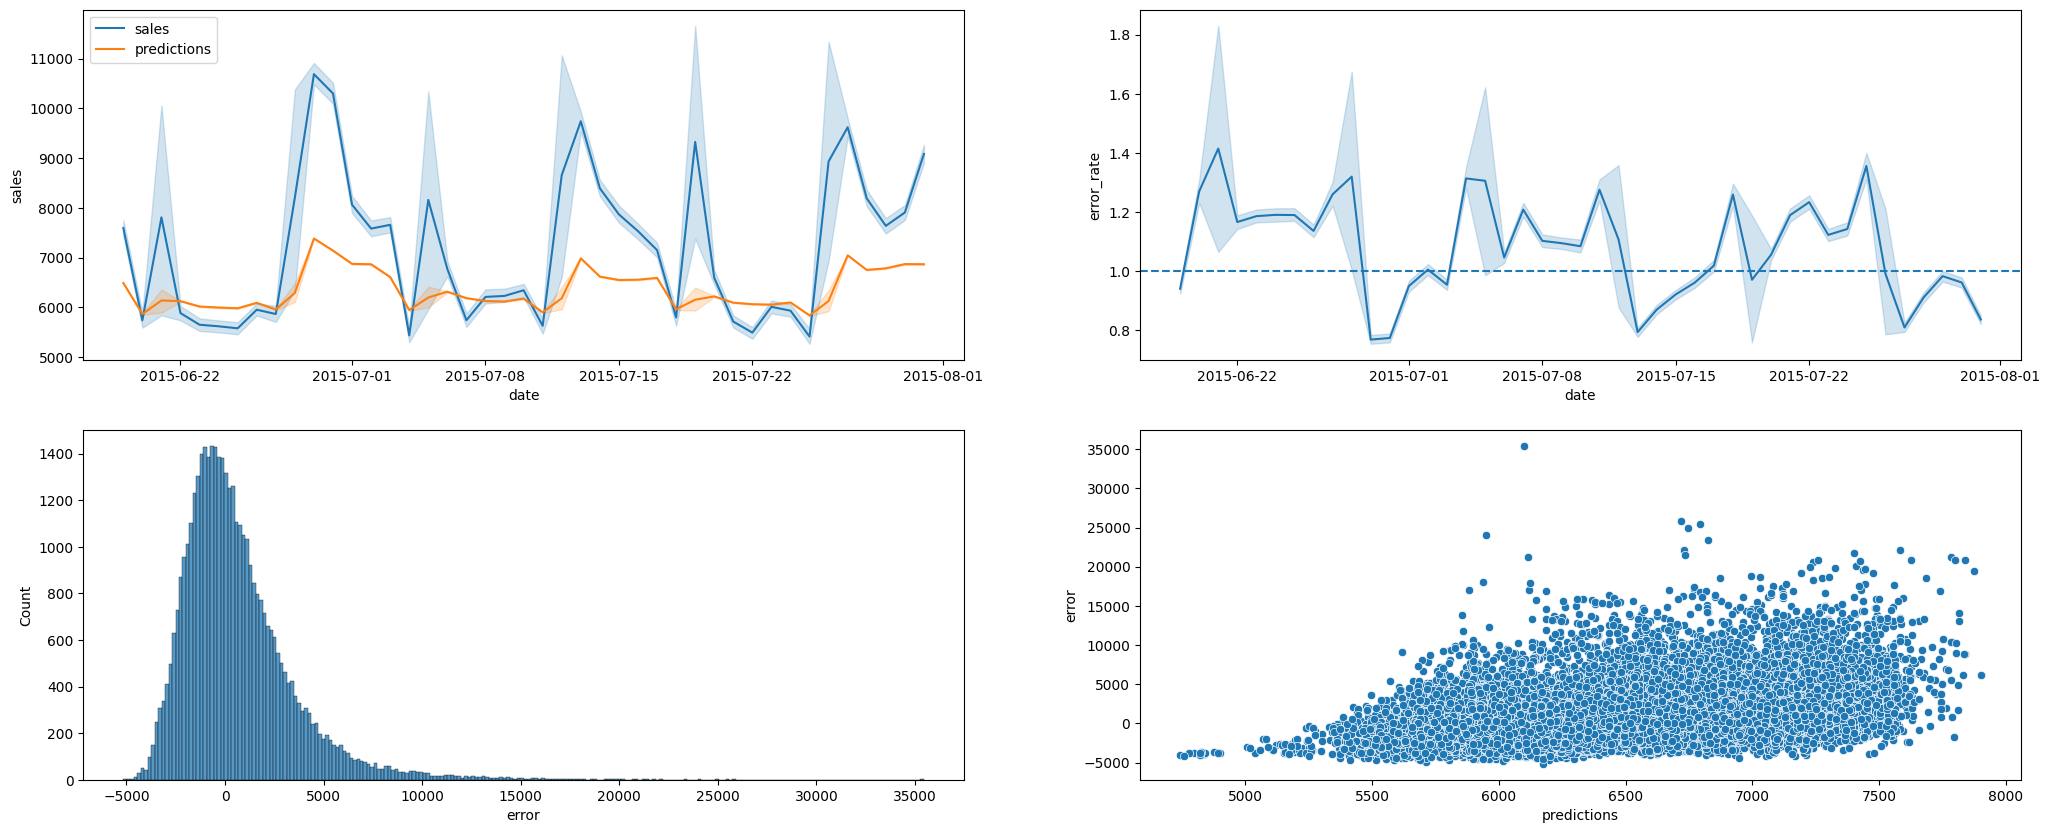

In [96]:
# vendas ao longo do tempo - real x previsão
plt.figure( figsize = (25,10) )
plt.subplot( 2 , 2 , 1 )
sns.lineplot( x = 'date', y = 'sales', data = df9 , label = 'sales')
sns.lineplot( x = 'date', y = 'predictions', data = df9 , label = 'predictions')

plt.subplot( 2 ,2 , 2 )
sns.lineplot( x = 'date', y = 'error_rate', data = df9 )
plt.axhline( 1,linestyle = '--' )

plt.subplot( 2 , 2 ,3 )
sns.histplot( df9['error'] )

plt.subplot( 2 , 2 ,4 )
sns.scatterplot( x = df9['predictions'], y = df9['error'], data = df9 )

# 10.0. - STEP 10 - DEPLOY MODEL TO PRODUCTION

In [101]:
# save trained model
pickle.dump( model_xgb_tuned, open(r'D:\repos\rossmann_sales\models\trained_model.pkl', 'wb') )


## 10.1. - Rossmann Class

In [102]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime as dt

class Rossmann( object ):
    def __init__( self ):
        self.home_path = r'\Users\oscar\Documents\repos\rossmann_sales'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + '\parameter/competition_distance_scaler.pkl' , 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + '\parameter/competition_time_month_scaler.pkl' , 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + '\parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + '\parameter/year_scaler.pkl' , 'rb' ) )
        self.store_type_scaler             = pickle.load( open( self.home_path + '\parameter/store_type_scaler.pkl' , 'rb' ) )
        
    def data_cleaning( self, df1 ):
        # crio uma lista com o nome das colunas antigos
        cols_old = ['Store', 'DayOfWeek', 'Date','Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        # coloco as colunas no estilo snake_case
        snake_case = lambda x : inflection.underscore( x ) # defino a lambda function

        # aplico o map para cada nome cols_old e crio a lista cols_new
        cols_new = list( map( snake_case, cols_old ) )

        # renomeio as coluanas do dataset
        df1.columns = cols_new

        # alterando o tipo da coluna date de int para date 64 
        df1['date'] = pd.to_datetime( df1['date'] )

        #competition_distance - Considero que na é igual a não competição. Se eu subsituir na por uma distancia muito grande seria o mesmo que dizer que não existe competição ( o valor máximo df1['competition_distance'] é 75860.0 )
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

        #competition_open_since_month - Considero que quando tiver "na" o competidor abriu no mesmo mes da coluna date ( data da venda ) -- para cada linha "na" pego o mes da coluna date e substituo na coluna competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

        #competition_open_since_year - mesma lógica do competition_open_since_month mas aplicado ao ano
        df1['competition_open_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['competition_open_since_year']                                                 ) else x['competition_open_since_year'], axis = 1)

        #promo2_since_week - Vou considerar que onde tiver "na" a loja não participou da promoção. Então vou substituir o na pela semana da data na coluna date ( data da venda)
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'] , axis = 1)

        #promo2_since_year - mesma lógica da promo2_since_week só que substituindo pelo ano
        df1['promo2_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'] , axis = 1 )

        #promo_interval
        month_map = { 1 : 'Jan', 2 :  'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'  } # crio um dicionario com os meses de acordo com os valores da coluna promo_interval

        df1['month_map'] = df1['date'].dt.month.map( month_map ) # substituo o numero do mes pelo nome

        df1['promo_interval'].fillna( 0 , inplace = True ) # substituo os na por 0

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1) # para cada linha verifico se o valor da coluna month_map existe na coluna promo_interval, se existir retorno 1 ( participa da promoção ) se não existir 0 ( não participa )

        # alterando o tipo da coluna competition_open_since_month  de float64 para int
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )

        # alterando o tipo da coluna competition_open_since_year de float64 para int
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

        # alterando o tipo da coluna promo2_since_week de float 64para int
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )

        # alterando o tipo da coluna promo2_since_year de float64 para int
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' ) 
        
        return df1
    
    def feature_engineering( self, df2 ):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        #=======================================================================================================================#

        # competition since - nova coluna que leva em consideração o ano e o mes da competição
        df2['competition_since'] = df2.apply( lambda x: dt.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ) , axis= 1) 

        # competition time month - Tempo de competição em meses
        df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

        # promo since - Desde quando a promoção ativa
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x : dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta(  days = 7 ) )
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days ).astype( 'int64' )

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # filtros as variáveis que não terei no momento da predição
        df2 = df2.loc[ ( df2['open'] != 0 ) , : ]

        # filtragem de colunas - as colunas que não vou passar no momento da predição. Neste caso customers
        cols_drop = ['open', 'promo_interval', 'month_map' ]

        df2 = df2.drop( cols_drop, axis = 1  )
        
        return df2
    
    def data_preparation( self, df5 ):
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        
        # state holiday - One Hot Encoding
        df5 = pd.get_dummies( df5 , prefix = 'state_holiday', columns = ['state_holiday'] )

        # store_type - Labelencoder
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assorment - ordinal encoding
        assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi / 7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi / 7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x : np.sin( x * ( 2. * np.pi / 30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x : np.cos( x * (2. * np.pi / 30) ) )

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 )  ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi / 52 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin',
                        'day_of_week_cos','month_cos','month_sin','day_sin','day_cos','week_of_year_cos','week_of_year_sin']
        
        return df5[ cols_selected ]  
    
    def get_prediction( self, model, original_data, test_data ):
        # faz a predicao
        pred = model.predict( test_data )
        
        # anexa ao df original
        original_data['predictions'] = np.expm1( pred )
        
        return original_data.to_json( orient = 'records', date_format = 'iso' )

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
C:\Users\oscar\AppData\Local\Temp\ipykernel_15380\3730260167.py:11: SyntaxWarning: invalid escape sequence '\p'
  self.competition_distance_scaler   = pickle.load( open( self.home_path + '\parameter/competition_distance_scaler.pkl' , 'rb' ) )
C:\Users\oscar\AppData\Local\Temp\ipykernel_15380\3730260167.py:12: SyntaxWarning: invalid escape sequence '\p'
  self.competition_time_month_scaler = pickle.load( open( self.home_path + '\parameter/competition_time_month_scaler.pkl' , 'rb' ) )
C:

In [103]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime as dt

class Rossmann( object ):
    def __init__( self ):
        # set home path for the project
        self.home_path = r'\Users\oscar\Documents\repos\rossmann_sales'
        
        # load pre-trained scalers for various features
        self.competition_distance_scaler   = pickle.load( open( self.home_path + r'\parameter/competition_distance_scaler.pkl' , 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + r'\parameter/competition_time_month_scaler.pkl' , 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + r'\parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + r'\parameter/year_scaler.pkl' , 'rb' ) )
        self.store_type_scaler             = pickle.load( open( self.home_path + r'\parameter/store_type_scaler.pkl' , 'rb' ) )
        
    def data_cleaning( self, df1 ):
        # create a list with the original column names
        cols_old = ['Store', 'DayOfWeek', 'Date','Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        # convert column names to snake_case format
        snake_case = lambda x : inflection.underscore( x ) # define lambda function for conversion

        # apply the map function to convert each old column name to snake_case and create a new list
        cols_new = list( map( snake_case, cols_old ) )

        # rename columns in the dataframe
        df1.columns = cols_new

        # convert the 'date' column from int to datetime64 type
        df1['date'] = pd.to_datetime( df1['date'] )

        # competition_distance - consider 'na' as no competition. If I replace 'na' with a very large distance, it is the same as saying there is no competition (maximum value of df1['competition_distance'] is 75860.0)
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

        # competition_open_since_month - consider 'na' as meaning the competitor opened in the same month as the sale date. Replace 'na' with the month from the sale date column
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

        # competition_open_since_year - same logic as for competition_open_since_month but for the year
        df1['competition_open_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)

        # promo2_since_week - assume 'na' means the store did not participate in the promotion. Replace 'na' with the week number of the sale date
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'] , axis = 1)

        # promo2_since_year - same logic as promo2_since_week but replace with the year
        df1['promo2_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'] , axis = 1 )

        # promo_interval - create a dictionary for month names corresponding to the month values in the promo_interval column
        month_map = { 1 : 'Jan', 2 :  'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'  }

        # map month numbers to month names
        df1['month_map'] = df1['date'].dt.month.map( month_map )

        # replace 'na' values in the promo_interval column with 0
        df1['promo_interval'].fillna( 0 , inplace = True )

        # create a new column 'is_promo' that indicates if the store is running a promotion during the current month
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)

        # convert 'competition_open_since_month' to integer type
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )

        # convert 'competition_open_since_year' to integer type
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

        # convert 'promo2_since_week' to integer type
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )

        # convert 'promo2_since_year' to integer type
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' ) 
        
        return df1
    
    def feature_engineering( self, df2 ):
        # extract year from the 'date' column
        df2['year'] = df2['date'].dt.year

        # extract month from the 'date' column
        df2['month'] = df2['date'].dt.month

        # extract day from the 'date' column
        df2['day'] = df2['date'].dt.day

        # extract week number of the year from the 'date' column
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # create a year-week column
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition_since - new column that combines the competition's open year and month
        df2['competition_since'] = df2.apply( lambda x: dt.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ) , axis= 1) 

        # competition_time_month - calculate competition time in months
        df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

        # promo_since - calculate when the promotion started
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x : dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta(  days = 7 ) )
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days ).astype( 'int64' )

        # assortment - map 'a', 'b', 'c' values to 'basic', 'extra', 'extended'
        df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday - map 'a', 'b', 'c' to respective holiday names
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # filter out rows where the store is closed (open == 0)
        df2 = df2.loc[ ( df2['open'] != 0 ) , : ]

        # drop unnecessary columns for prediction
        cols_drop = ['open', 'promo_interval', 'month_map' ]
        df2 = df2.drop( cols_drop, axis = 1  )
        
        return df2
    
    def data_preparation( self, df5 ):
        # scale competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        
        # scale competition time in months
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        # scale promo time in weeks
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # scale year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        
        # apply One-Hot Encoding to 'state_holiday' column
        df5 = pd.get_dummies( df5 , prefix = 'state_holiday', columns = ['state_holiday'] )

        # apply label encoding to 'store_type' column
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # apply ordinal encoding to 'assortment' column
        assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        # apply trigonometric transformations to 'day_of_week', 'month', 'day', and 'week_of_year' columns
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi / 7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi / 7 ) ) )

        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

        df5['day_sin'] = df5['day'].apply( lambda x : np.sin( x * ( 2. * np.pi / 30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x : np.cos( x * (2. * np.pi / 30) ) )

        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 )  ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi / 52 ) ) )
        
        # select relevant columns for the final dataframe
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin',
                        'day_of_week_cos','month_cos','month_sin','day_sin','day_cos','week_of_year_cos','week_of_year_sin']
        
        return df5[ cols_selected ]  
    
    def get_prediction( self, model, original_data, test_data ):
        # make prediction using the trained model
        pred = model.predict( test_data )
        
        # append the prediction to the original dataframe
        original_data['predictions'] = np.expm1( pred )
        
        # return the data as a JSON format
        return original_data.to_json( orient = 'records', date_format = 'iso' )


## 10.2. - API HANDLER

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request
from Rossmann          import Rossmann

# loading model
model = pickle.load( open(r'\Users\oscar\Documents\repos\rossmann_sales\trained_model.pkl' , 'rb') )

# initialize api
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods = ['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # se tiver dados
        if isinstance( test_json, dict ): # se tiver chave - valor
            
            test_raw = pd.DataFrame( test_json, index = [0] ) # trato como única linha
            
        else:
            
            test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
            
            # instancia classe rossmann
            pipeline = Rossmann()
            
            # data cleaning
            df1 = pipeline.data_cleaning( test_raw )
            
            # feature engineering
            df2 = pipeline.feature_engineering( df1 )
            
            # data preparation
            df3 = pipeline.data_preparation( df2 )
            
            # prediction
            df_response = pipeline.get_prediction( model, test_raw, df3 )
            
            return df_response
            
    else:
        return Response( '{}', status = 200, mimetype = 'application/json' )

if __name__ == '__main__':
    app.run( ${{ secrets.URL_LOCAL }} )

## 10.3. - TEST API

In [ ]:
# loading test dataset
df10 = pd.read_csv( 'data/test.csv' )

# merge
df_test = pd.merge( df10 , df_store_raw, how = 'left', on = 'Store' )

# remove closed days
df_test = df_test.loc[ df_test['Open'] != 0, : ] # remove closed days
df_test = df_test.loc[~ df_test['Open'].isnull(), : ] # remove nulls on columns open
df_subsmission = df_test['Id'].reset_index( drop = True ) # salvo id para submissão

In [ ]:
# remove columns ID
df_test = df_test.drop( 'Id', axis = 1 )

In [ ]:
# convert dataframe into json
data = json.dumps( df_test.to_dict( orient = 'records' ) )

In [ ]:
# API call
url = ${{ secrets.URL_API }}
header = {'Content-type' : 'application/json'}

data = data

r = requests.post( url, data = data, headers = header ) # response in json
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )
d1

## 10.4. - Kaggle Subsmission

In [ ]:
# carregando os dados de teste
df_test_0 = pd.read_csv( 'data/test.csv' ) 
df_test = pd.merge( df_test_0 , df_store_raw, how = 'left', on = 'Store' )
df_test = df_test.drop( 'Id', axis = 1 )

In [ ]:
# preparando os dados de teste
df_test_sub = prepare_data_test( df_test )

In [ ]:
# prediction
# loading model
model = pickle.load( open(r'\Users\oscar\Documents\repos\rossmann_sales\trained_model.pkl' , 'rb') )
#y_hat = pd.DataFrame( model.predict( df_test_sub ) )

In [ ]:
# preparando o sample submission
submission = df_test_0[['Id']]
submission['Sales'] = y_hat

# exportando para excel para carregar no kaggle
submission.to_csv( 'test_submission.csv', index = False )
